# Case 1: Time Series Forecasting with LSTMs for TFP using PyTorch in Python 

In economics, total-factor productivity (TFP), also called multi-factor productivity, is usually measured as the ratio of aggregate output (e.g., GDP) to aggregate inputs. Under some simplifications about the production technology, growth in TFP becomes the portion of growth in output not explained by growth in traditionally measured inputs of labour and capital used in production. TFP is calculated by dividing output by the weighted average of labour and capital input, with the standard weighting of 0.7 for labour and 0.3 for capital. Total factor productivity is a measure of economic efficiency and accounts for part of the differences in cross-country per-capita income. The rate of TFP growth is calculated by subtracting growth rates of labor and capital inputs from the growth rate of output.

In the terminal, please install pytorch: conda install -c pytorch pytorch
(https://anaconda.org/pytorch/pytorch).

Importing the libraries and setting up the environment:

In [1]:
import torch

import os
import csv
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data exploration

Let's load the data and have a peek:

In [2]:
path = os.getcwd()
path

'/Users/robertomartins/Desktop/Challenge_4i'

In [3]:
os.chdir(path)

In [4]:
df = pd.read_csv('TFP.csv')
df

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179
...,...,...,...
181,MEX,2007,1.013673
182,MEX,2008,0.991548
183,MEX,2009,0.915879
184,MEX,2010,0.941604


Two things to note here:

- The year is going to be converted to a date format and used as an index.
- The data for each country has to be processed separately.

Let's start by formating the year as a date and using it as an index:

In [5]:
data = df.iloc[:,:].values

with open('TFP_mod.csv', mode='w') as input_file:
    fieldnames = ['isocode', 'year', 'rtfpna']
    writer = csv.DictWriter(input_file,fieldnames = fieldnames)
    
    writer.writeheader()
    for i in range(len(data)-1):
        writer.writerow({'isocode': data[i,0], 'year': '1/1/' + str(data[i,1]), 'rtfpna': data[i,2]})

In [6]:
df = pd.read_csv('TFP_mod.csv', index_col ="year")
df

,isocode,rtfpna
year,,
1/1/1950,USA,0.617148
1/1/1951,USA,0.629588
1/1/1952,USA,0.638451
1/1/1953,USA,0.651858
1/1/1954,USA,0.646179
...,...,...
1/1/2006,MEX,1.011751
1/1/2007,MEX,1.013673
1/1/2008,MEX,0.991548


In [7]:
df_USA = df.iloc[:62, 1:].T

In [8]:
df_USA

year,1/1/1950,1/1/1951,1/1/1952,1/1/1953,1/1/1954,1/1/1955,1/1/1956,1/1/1957,1/1/1958,1/1/1959,...,1/1/2002,1/1/2003,1/1/2004,1/1/2005,1/1/2006,1/1/2007,1/1/2008,1/1/2009,1/1/2010,1/1/2011
rtfpna,0.617148,0.629588,0.638451,0.651858,0.646179,0.668773,0.661,0.662165,0.654813,0.68068,...,0.966917,0.97591,0.992058,1.0,1.004,1.006595,0.998499,0.986738,1.009463,1.020392


In [9]:
df_CAN = df.iloc[62:124, 1:].T

In [10]:
df_CAN

year,1/1/1950,1/1/1951,1/1/1952,1/1/1953,1/1/1954,1/1/1955,1/1/1956,1/1/1957,1/1/1958,1/1/1959,...,1/1/2002,1/1/2003,1/1/2004,1/1/2005,1/1/2006,1/1/2007,1/1/2008,1/1/2009,1/1/2010,1/1/2011
rtfpna,0.843335,0.855123,0.896489,0.910658,0.875178,0.927682,0.979869,0.969728,0.959928,0.974205,...,1.039474,1.016517,1.008693,1.0,0.995132,0.981433,0.958357,0.926482,0.932567,0.929405


In [11]:
df_MEX = df.iloc[124:, 1:].T

In [12]:
df_MEX

year,1/1/1950,1/1/1951,1/1/1952,1/1/1953,1/1/1954,1/1/1955,1/1/1956,1/1/1957,1/1/1958,1/1/1959,...,1/1/2001,1/1/2002,1/1/2003,1/1/2004,1/1/2005,1/1/2006,1/1/2007,1/1/2008,1/1/2009,1/1/2010
rtfpna,0.798159,0.860931,0.876968,0.855204,0.929168,0.981849,1.02716,1.074038,1.09155,1.085564,...,1.036735,1.005033,0.991272,0.994963,1.0,1.011751,1.013673,0.991548,0.915879,0.941604


Let's check for missing values:

In [13]:
df_USA.isnull().sum().sum()

0

In [14]:
df_CAN.isnull().sum().sum()

0

In [15]:
df_MEX.isnull().sum().sum()

0

Everything seems to be in place. Let's format the index as datetime:

In [16]:
usa = df_USA.sum(axis=0)
usa.index = pd.to_datetime(usa.index)
usa

year
1950-01-01    0.617148
1951-01-01    0.629588
1952-01-01    0.638451
1953-01-01    0.651858
1954-01-01    0.646179
                ...   
2007-01-01    1.006595
2008-01-01    0.998499
2009-01-01    0.986738
2010-01-01    1.009463
2011-01-01    1.020392
Length: 62, dtype: float64

In [17]:
can = df_CAN.sum(axis=0)
can.index = pd.to_datetime(can.index)
can

year
1950-01-01    0.843335
1951-01-01    0.855123
1952-01-01    0.896489
1953-01-01    0.910658
1954-01-01    0.875178
                ...   
2007-01-01    0.981433
2008-01-01    0.958357
2009-01-01    0.926482
2010-01-01    0.932567
2011-01-01    0.929405
Length: 62, dtype: float64

In [18]:
mex = df_MEX.sum(axis=0)
mex.index = pd.to_datetime(mex.index)
mex

year
1950-01-01    0.798159
1951-01-01    0.860931
1952-01-01    0.876968
1953-01-01    0.855204
1954-01-01    0.929168
                ...   
2006-01-01    1.011751
2007-01-01    1.013673
2008-01-01    0.991548
2009-01-01    0.915879
2010-01-01    0.941604
Length: 61, dtype: float64

In [19]:
usa.shape

(62,)

In [20]:
can.shape

(62,)

In [21]:
mex.shape

(61,)

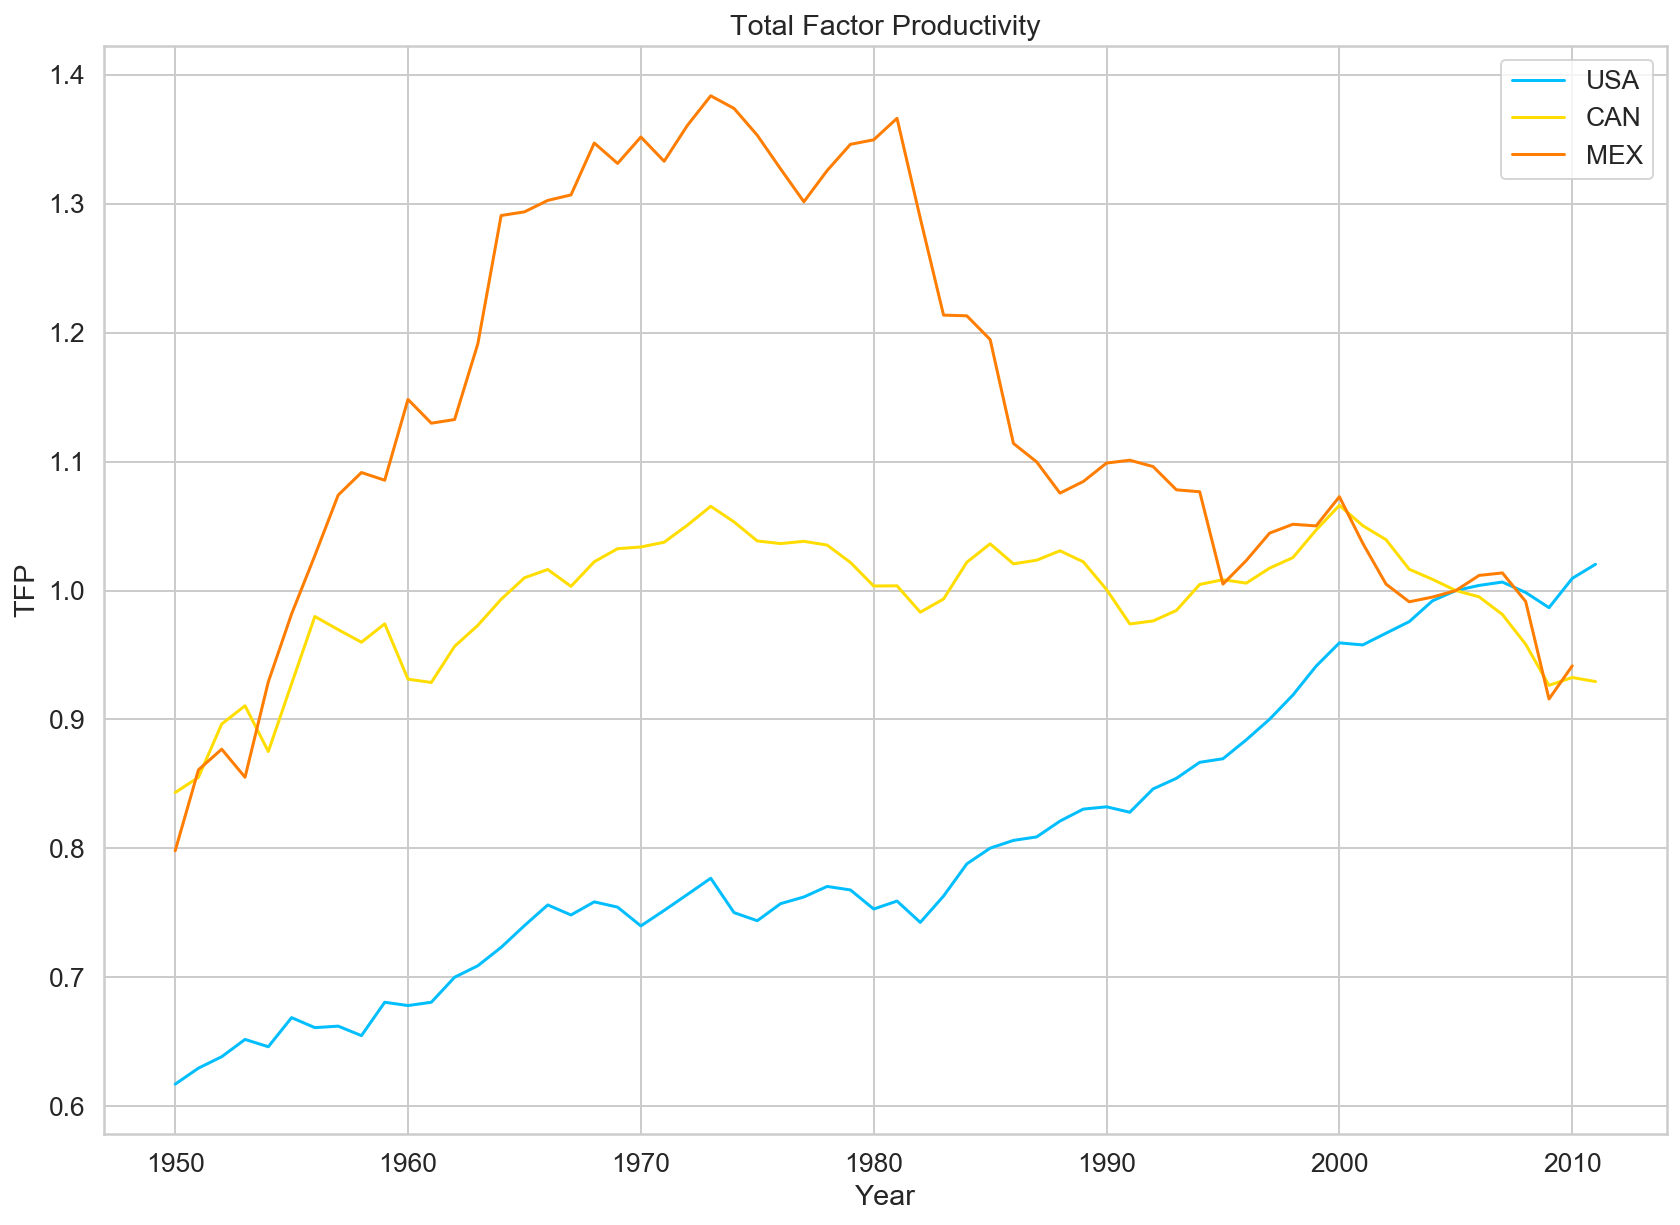

In [22]:
plt.plot(usa, label="USA")
plt.plot(can, label="CAN")
plt.plot(mex, label="MEX")
plt.xlabel('Year')
plt.ylabel('TFP')
plt.title("Total Factor Productivity")
plt.legend();

The behavior of the TFP is very different from USA, CAN and MEX. The USA has a clear growing trend in the TFP, while in CAN and MEX the TFP not only fluctuates but also decreases over the last 10 observed years. Of course, all three lines cross at (2005,1).

# USA

## Preprocessing

We'll reserve the last 12 years for testing and use the remaining years for training:

In [23]:
test_data_size = 12

train_data = usa[:-test_data_size]
test_data = usa[-test_data_size:]

train_data.shape

(50,)

We normally scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. We'll use the `MinMaxScaler` from scikit-learn:

In [24]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

Currently, we have a big sequence of yearly data. We'll convert it into smaller ones:

In [25]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [26]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let's dive in:

In [27]:
X_train.shape

torch.Size([44, 5, 1])

In [28]:
X_train[:2]

tensor([[[0.0000],
         [0.0384],
         [0.0657],
         [0.1071],
         [0.0895]],

        [[0.0384],
         [0.0657],
         [0.1071],
         [0.0895],
         [0.1592]]])

In [29]:
y_train.shape

torch.Size([44, 1])

In [30]:
y_train[:2]

tensor([[0.1592],
        [0.1353]])

In [31]:
train_data[:10]

array([[0.        ],
       [0.03836989],
       [0.06570539],
       [0.10705563],
       [0.08954083],
       [0.15922498],
       [0.13525093],
       [0.13884382],
       [0.11616746],
       [0.19594789]])

## Building a model

We'll encapsulate the complexity of our model into a class that extends from `torch.nn.Module`:

In [32]:
class TFPPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(TFPPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

Our `TFPPredictor` contains 3 methods:
- constructor - initialize all helper data and create the layers
- `reset_hidden_state` - we'll use a stateless LSTM, so we need to reset the state after each example
- `forward` - get the sequences, pass all of them through the LSTM layer, at once. We take the output of the last time step and pass it through our linear layer to get the prediction.

## Training

Let's build a helper function for the training of our model (we'll reuse it later):

In [33]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None,
  num_epochs = 100
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

Note that the hidden state is reset at the start of each epoch. We don't use batches of data our model sees every example at once. We'll use mean squared error to measure our training and test error. We'll record both. 

Let's create an instance of our model and train it:

In [34]:
model = TFPPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=4
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test,
  1000
)

Epoch 0 train loss: 10.027140617370605 test loss: 7.920776844024658
Epoch 10 train loss: 1.887125849723816 test loss: 3.000230312347412
Epoch 20 train loss: 1.7754496335983276 test loss: 3.1467854976654053
Epoch 30 train loss: 1.3784620761871338 test loss: 1.493391513824463
Epoch 40 train loss: 1.496709942817688 test loss: 5.0700273513793945
Epoch 50 train loss: 0.8124482035636902 test loss: 0.41284871101379395
Epoch 60 train loss: 0.4271933138370514 test loss: 2.1625113487243652
Epoch 70 train loss: 0.4854011833667755 test loss: 2.382406711578369
Epoch 80 train loss: 0.45580756664276123 test loss: 1.3621056079864502
Epoch 90 train loss: 0.41313719749450684 test loss: 2.693545341491699
Epoch 100 train loss: 0.44047725200653076 test loss: 1.1575393676757812
Epoch 110 train loss: 0.8558631539344788 test loss: 0.05862906575202942
Epoch 120 train loss: 0.5779153108596802 test loss: 1.1934620141983032
Epoch 130 train loss: 0.48687925934791565 test loss: 0.9431836605072021
Epoch 140 train lo

Let's have a look at the train and test loss:

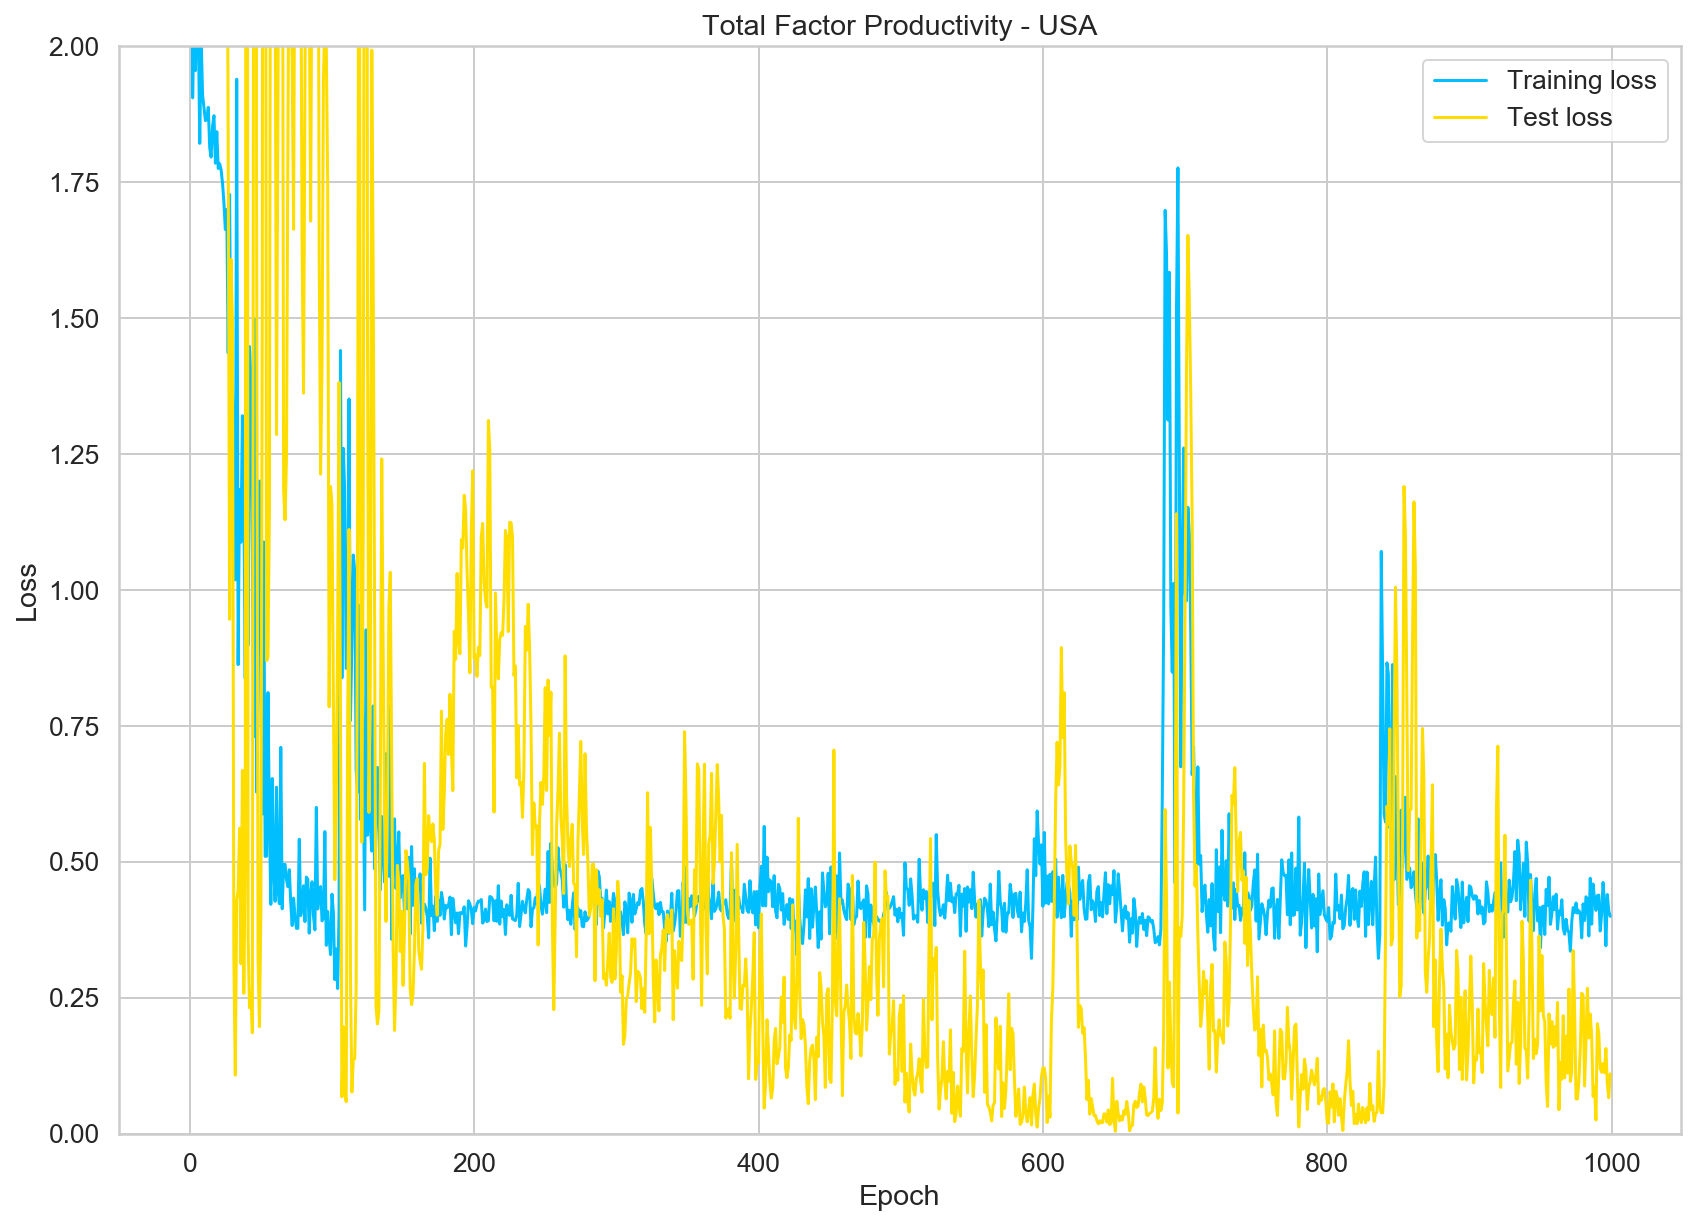

In [35]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 2))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Total Factor Productivity - USA")
plt.legend();

Our model's performance improves after 500 epochs or so.

## Predicting yearly data

Our model can (due to the way we've trained it) predict only a single year in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next years:

In [36]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

We have to reverse the scaling of the test data and the model predictions:

In [37]:
true_data = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

true_data

array([1.       , 1.0040003, 1.0065953, 0.9984993, 0.9867378, 1.0094631],
      dtype=float32)

In [38]:
predicted_data = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

predicted_data

array([1.0496212 , 1.04591435, 1.05973541, 1.06220149, 1.06134982,
       1.05137986])

Let's look at the results:

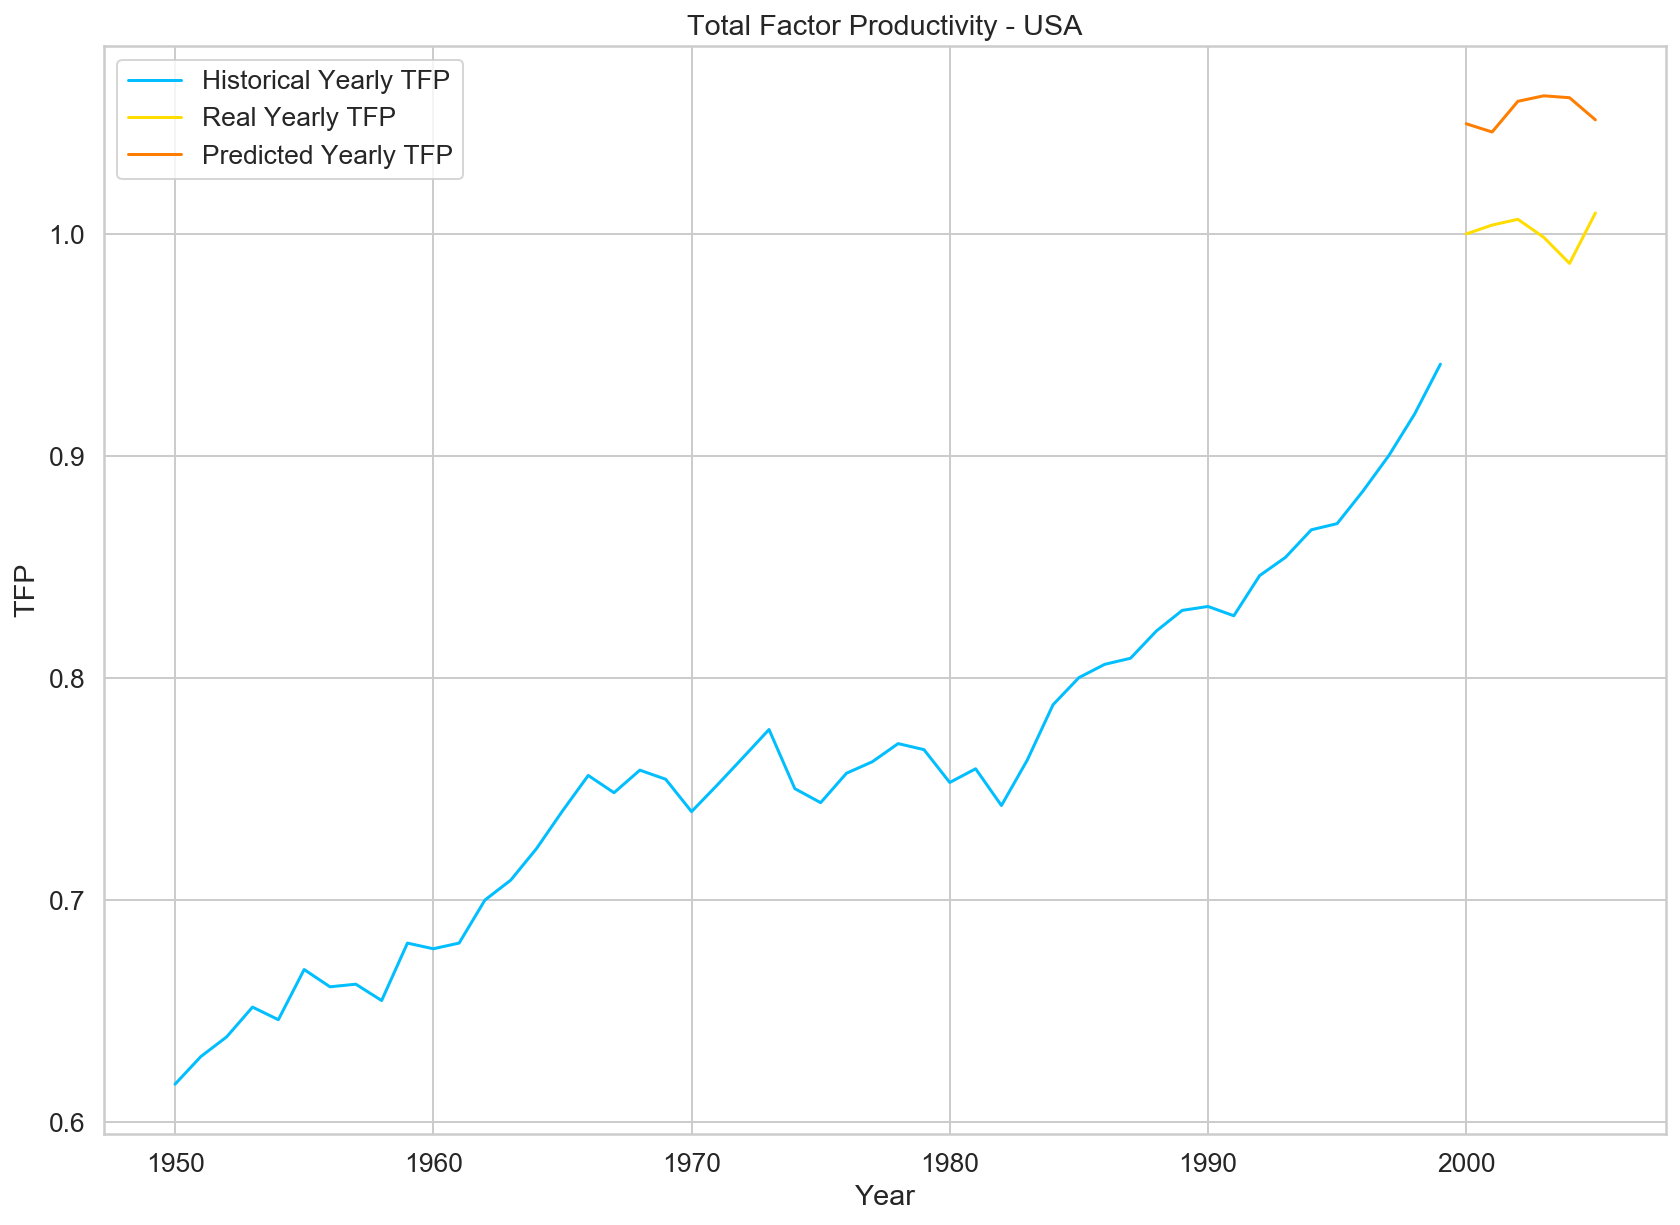

In [39]:
plt.plot(
  usa.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Yearly TFP'
)

plt.plot(
  usa.index[len(train_data):len(train_data) + len(true_data)], 
  true_data,
  label='Real Yearly TFP'
)

plt.plot(
  usa.index[len(train_data):len(train_data) + len(true_data)], 
  predicted_data, 
  label='Predicted Yearly TFP'
)
plt.xlabel('Year')
plt.ylabel('TFP')
plt.title("Total Factor Productivity - USA")
plt.legend();

Our model was able to catch the proper trend.

## Use all data for training

Now, we'll use all available data to train the same model:

In [40]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(usa, axis=1))

all_data = scaler.transform(np.expand_dims(usa, axis=1))

all_data.shape

(62, 1)

The preprocessing and training steps are the same:

In [41]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = TFPPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=4
)
model, train_hist, _ = train_model(model, X_all, y_all, None, None, 1000)

Epoch 0 train loss: 12.156671524047852
Epoch 10 train loss: 1.8669366836547852
Epoch 20 train loss: 1.681365728378296
Epoch 30 train loss: 1.6314301490783691
Epoch 40 train loss: 1.5398588180541992
Epoch 50 train loss: 2.1499526500701904
Epoch 60 train loss: 2.0242702960968018
Epoch 70 train loss: 1.6140191555023193
Epoch 80 train loss: 1.1280075311660767
Epoch 90 train loss: 0.5042233467102051
Epoch 100 train loss: 0.5334676504135132
Epoch 110 train loss: 0.5848780870437622
Epoch 120 train loss: 0.5791931748390198
Epoch 130 train loss: 0.47300347685813904
Epoch 140 train loss: 0.602738618850708
Epoch 150 train loss: 0.45173293352127075
Epoch 160 train loss: 0.42318132519721985
Epoch 170 train loss: 0.36705347895622253
Epoch 180 train loss: 0.5026231408119202
Epoch 190 train loss: 0.5057441592216492
Epoch 200 train loss: 0.49788641929626465
Epoch 210 train loss: 0.3491832911968231
Epoch 220 train loss: 0.33296501636505127
Epoch 230 train loss: 0.4027033746242523
Epoch 240 train loss: 2

Let's have a look at the train loss:

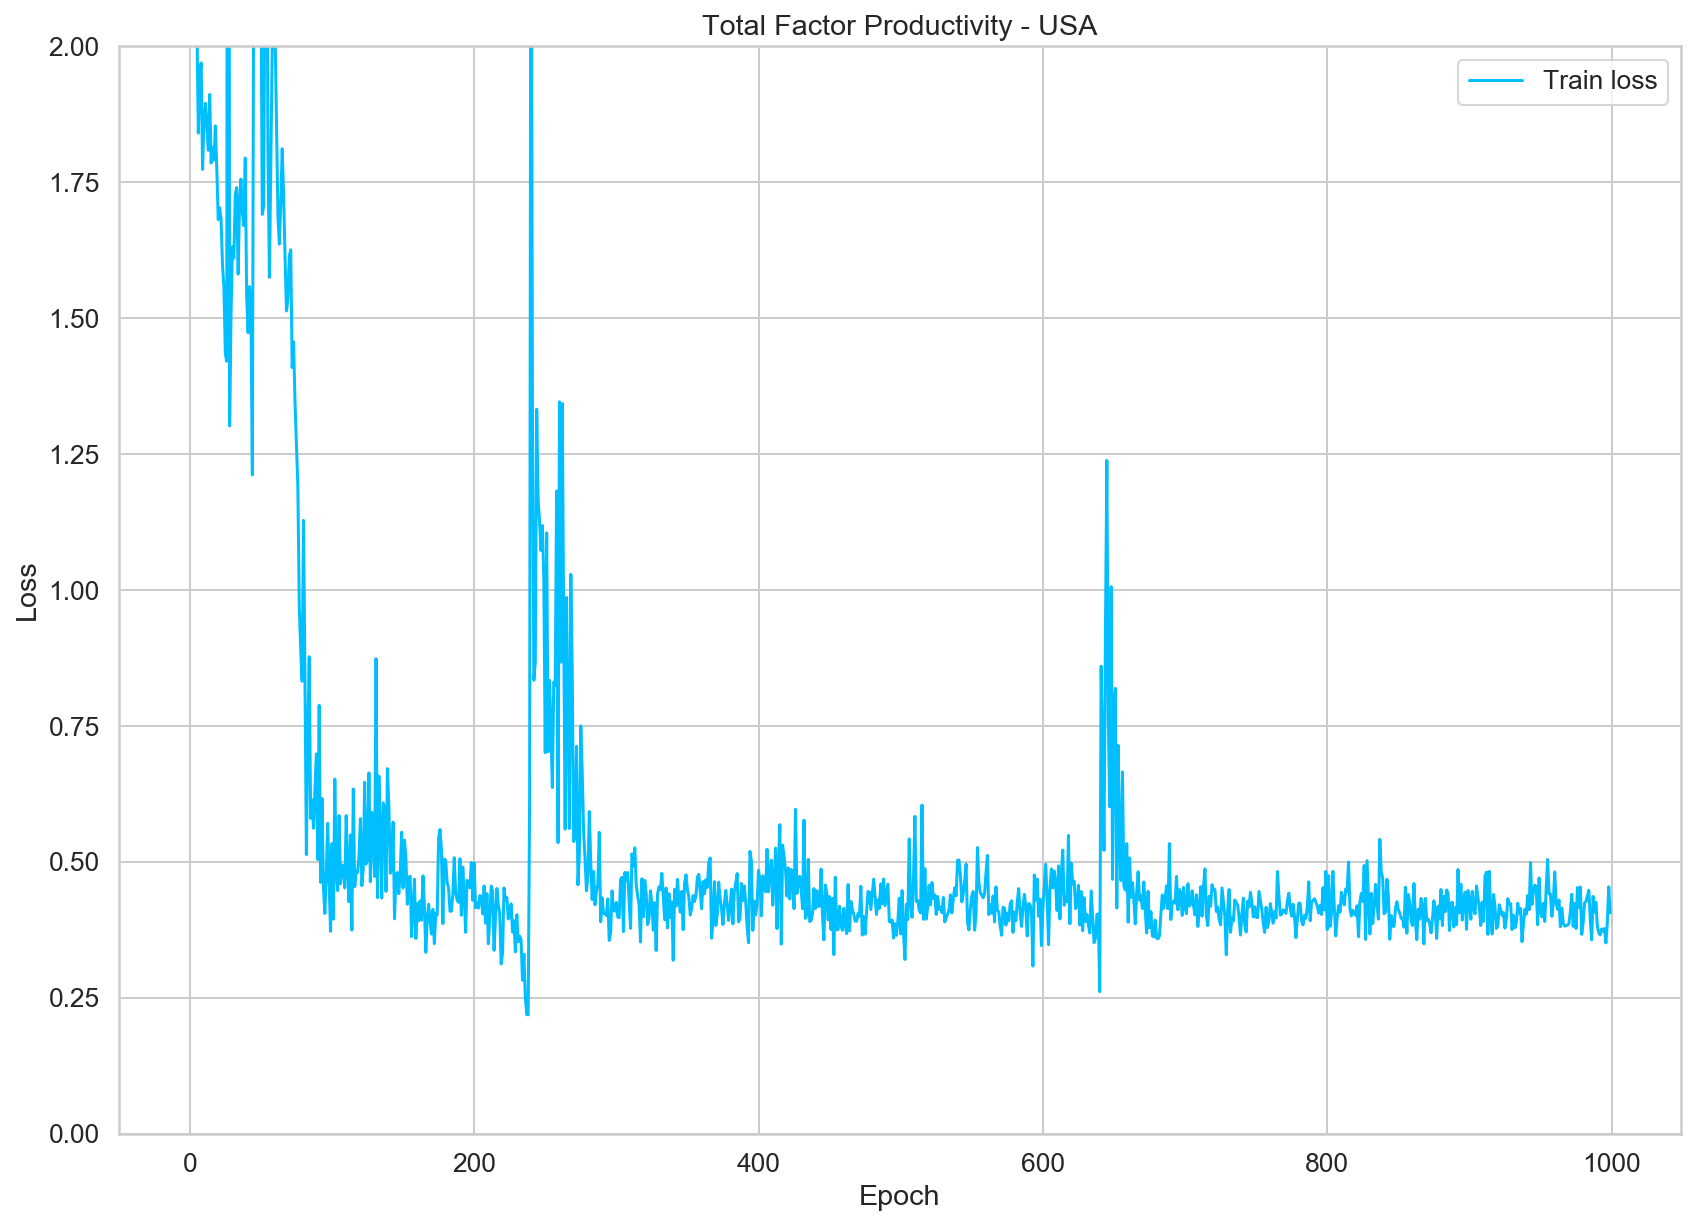

In [42]:
plt.plot(train_hist, label="Train loss")
plt.ylim((0, 2))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Total Factor Productivity - USA")
plt.legend();

## Predicting future cases

We'll use our "fully trained" model to predict the TFP for 10 years into the future:

In [43]:
YEARS_TO_PREDICT = 10

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(YEARS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

As before, we'll inverse the scaler transformation:

In [44]:
predicted_data = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
predicted_data

array([1.02732151, 1.063841  , 1.10751014, 1.14527768, 1.17809613,
       1.20051493, 1.21298555, 1.21827161, 1.22052761, 1.22118487])

To create a cool chart with the historical and predicted cases, we need to extend the date index of our data frame:

In [45]:
usa.index[-1]

Timestamp('2011-01-01 00:00:00')

In [46]:
predicted_index = pd.date_range(
  start=usa.index[-1],
  freq='Y',
  periods=YEARS_TO_PREDICT
)

predicted_index

DatetimeIndex(['2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31',
               '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31',
               '2019-12-31', '2020-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

In [47]:
predicted_data = pd.Series(
  data=predicted_data,
  index=predicted_index
)

predicted_data

2011-12-31    1.027322
2012-12-31    1.063841
2013-12-31    1.107510
2014-12-31    1.145278
2015-12-31    1.178096
2016-12-31    1.200515
2017-12-31    1.212986
2018-12-31    1.218272
2019-12-31    1.220528
2020-12-31    1.221185
Freq: A-DEC, dtype: float64

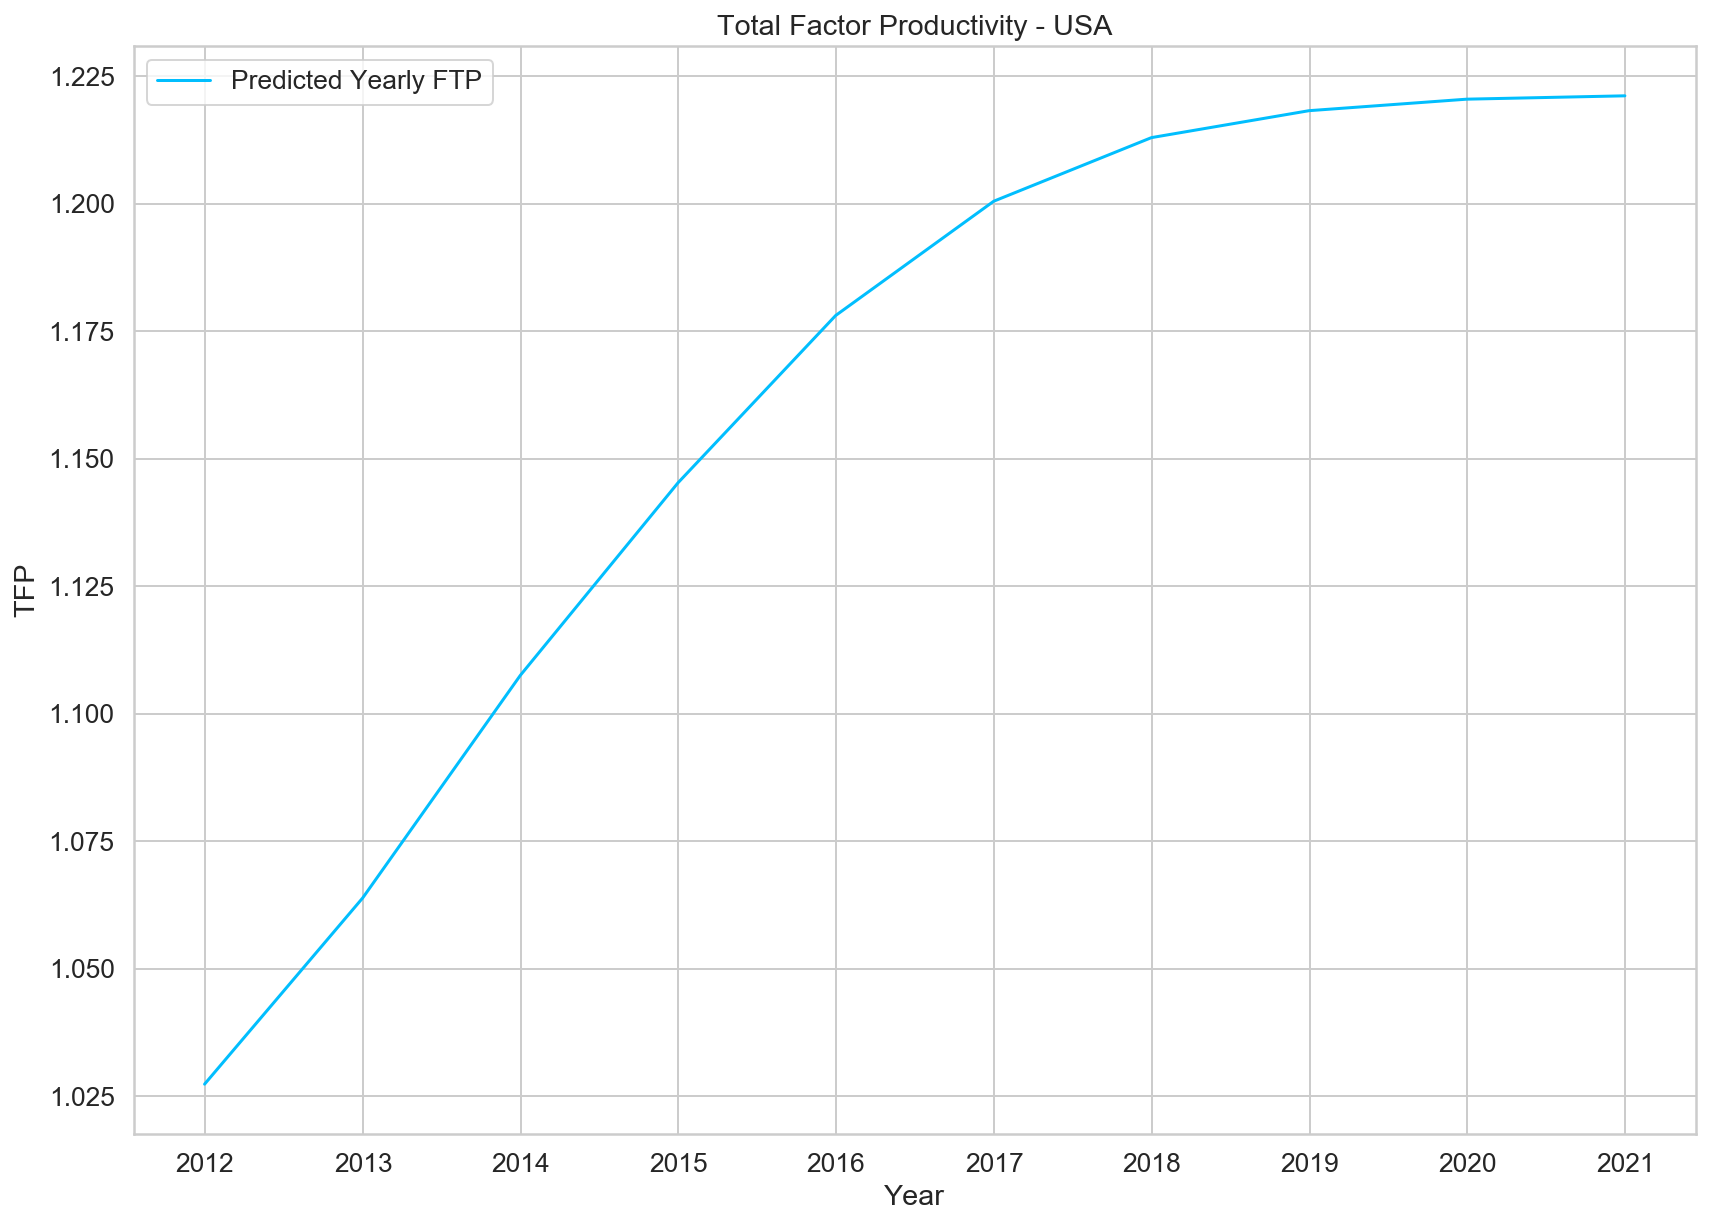

In [48]:
plt.plot(predicted_data, label='Predicted Yearly FTP')
plt.xlabel('Year')
plt.ylabel('TFP')
plt.title("Total Factor Productivity - USA")
plt.legend();

Now we can use all the data to plot the results:

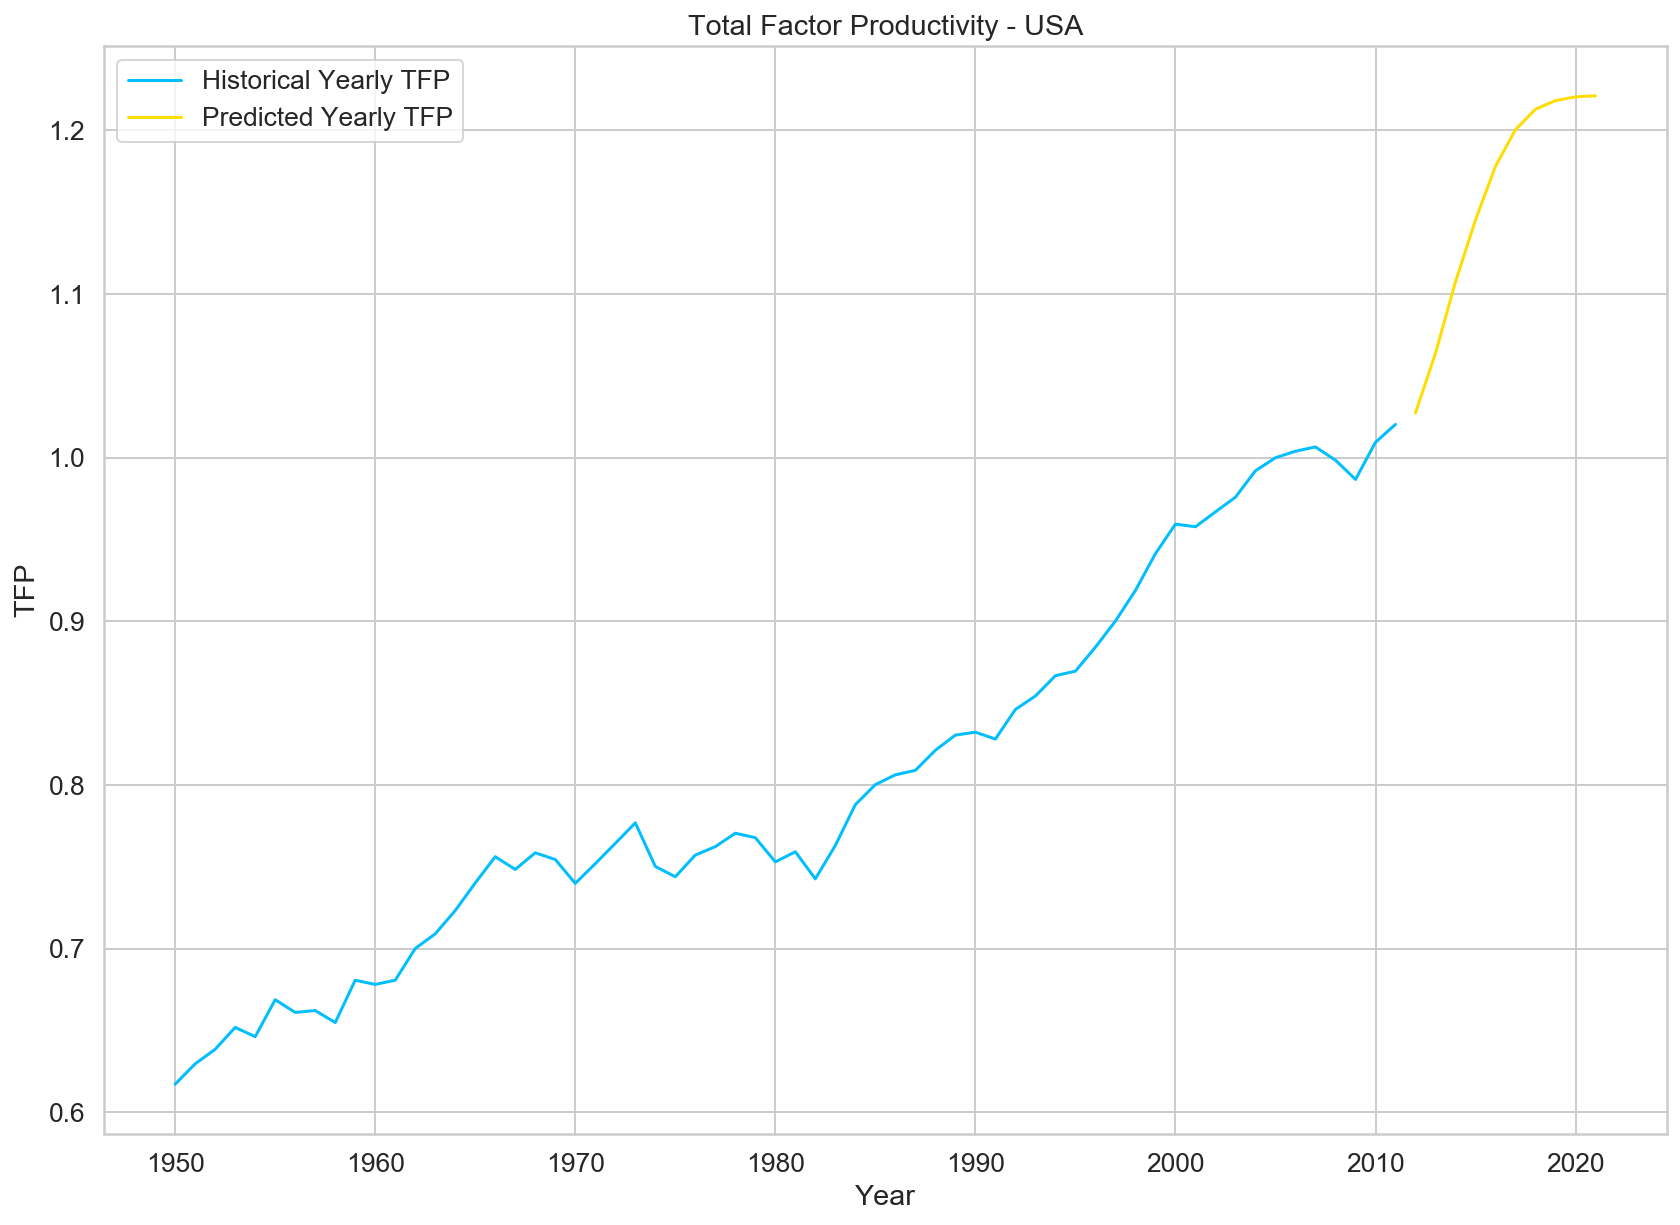

In [49]:
plt.plot(usa, label='Historical Yearly TFP')
plt.plot(predicted_data, label='Predicted Yearly TFP')
plt.xlabel('Year')
plt.ylabel('TFP')
plt.title("Total Factor Productivity - USA")
plt.legend();

Our model thinks that things will level up. Note that the more you go into the future, the more you shouldn't trust your model predictions.

# CAN

## Preprocessing

We'll reserve the last 12 years for testing and use the remaining years for training:

In [50]:
test_data_size = 12

train_data = can[:-test_data_size]
test_data = can[-test_data_size:]

train_data.shape

(50,)

We normally scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. We'll use the `MinMaxScaler` from scikit-learn:

In [51]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

Currently, we have a big sequence of yearly data. We'll convert it into smaller ones:

In [52]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let's dive in:

In [53]:
X_train.shape

torch.Size([44, 5, 1])

In [54]:
X_train[:2]

tensor([[[0.0000],
         [0.0531],
         [0.2394],
         [0.3032],
         [0.1434]],

        [[0.0531],
         [0.2394],
         [0.3032],
         [0.1434],
         [0.3799]]])

In [55]:
y_train.shape

torch.Size([44, 1])

In [56]:
y_train[:2]

tensor([[0.3799],
        [0.6150]])

In [57]:
train_data[:10]

array([[0.        ],
       [0.05309796],
       [0.23942554],
       [0.30324736],
       [0.14343157],
       [0.37992908],
       [0.61499586],
       [0.56931786],
       [0.52517665],
       [0.58948308]])

## Training

Let's create an instance of our model and train it:

In [67]:
model = TFPPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test,
  2000
)

Epoch 0 train loss: 24.614439010620117 test loss: 1.951794147491455
Epoch 10 train loss: 1.2978569269180298 test loss: 0.5128067135810852
Epoch 20 train loss: 1.0591061115264893 test loss: 0.28360143303871155
Epoch 30 train loss: 1.0385022163391113 test loss: 0.21073734760284424
Epoch 40 train loss: 0.9759848713874817 test loss: 0.2231042981147766
Epoch 50 train loss: 0.9605669975280762 test loss: 0.28239038586616516
Epoch 60 train loss: 0.9701536893844604 test loss: 0.28465622663497925
Epoch 70 train loss: 1.0102028846740723 test loss: 0.2858350872993469
Epoch 80 train loss: 0.9708564281463623 test loss: 0.28438055515289307
Epoch 90 train loss: 0.9252204298973083 test loss: 0.3005898594856262
Epoch 100 train loss: 0.9644050002098083 test loss: 0.29198911786079407
Epoch 110 train loss: 0.9445655345916748 test loss: 0.2967117130756378
Epoch 120 train loss: 0.9192118048667908 test loss: 0.2498677372932434
Epoch 130 train loss: 0.9323650002479553 test loss: 0.3076419234275818
Epoch 140 tr

Epoch 1150 train loss: 0.2336825132369995 test loss: 0.5789027214050293
Epoch 1160 train loss: 0.24283857643604279 test loss: 0.647808849811554
Epoch 1170 train loss: 0.18952415883541107 test loss: 0.80528724193573
Epoch 1180 train loss: 0.2037966102361679 test loss: 0.7306883931159973
Epoch 1190 train loss: 0.24422332644462585 test loss: 0.6875326037406921
Epoch 1200 train loss: 0.1896897554397583 test loss: 0.719140887260437
Epoch 1210 train loss: 0.17235755920410156 test loss: 0.7356023192405701
Epoch 1220 train loss: 0.15809857845306396 test loss: 0.746192216873169
Epoch 1230 train loss: 0.1548105776309967 test loss: 0.876298189163208
Epoch 1240 train loss: 0.15430471301078796 test loss: 1.1006262302398682
Epoch 1250 train loss: 0.17321987450122833 test loss: 1.0943682193756104
Epoch 1260 train loss: 0.20600642263889313 test loss: 1.1830018758773804
Epoch 1270 train loss: 0.07248207181692123 test loss: 1.2902336120605469
Epoch 1280 train loss: 0.13841290771961212 test loss: 0.89662

Let's have a look at the train and test loss:

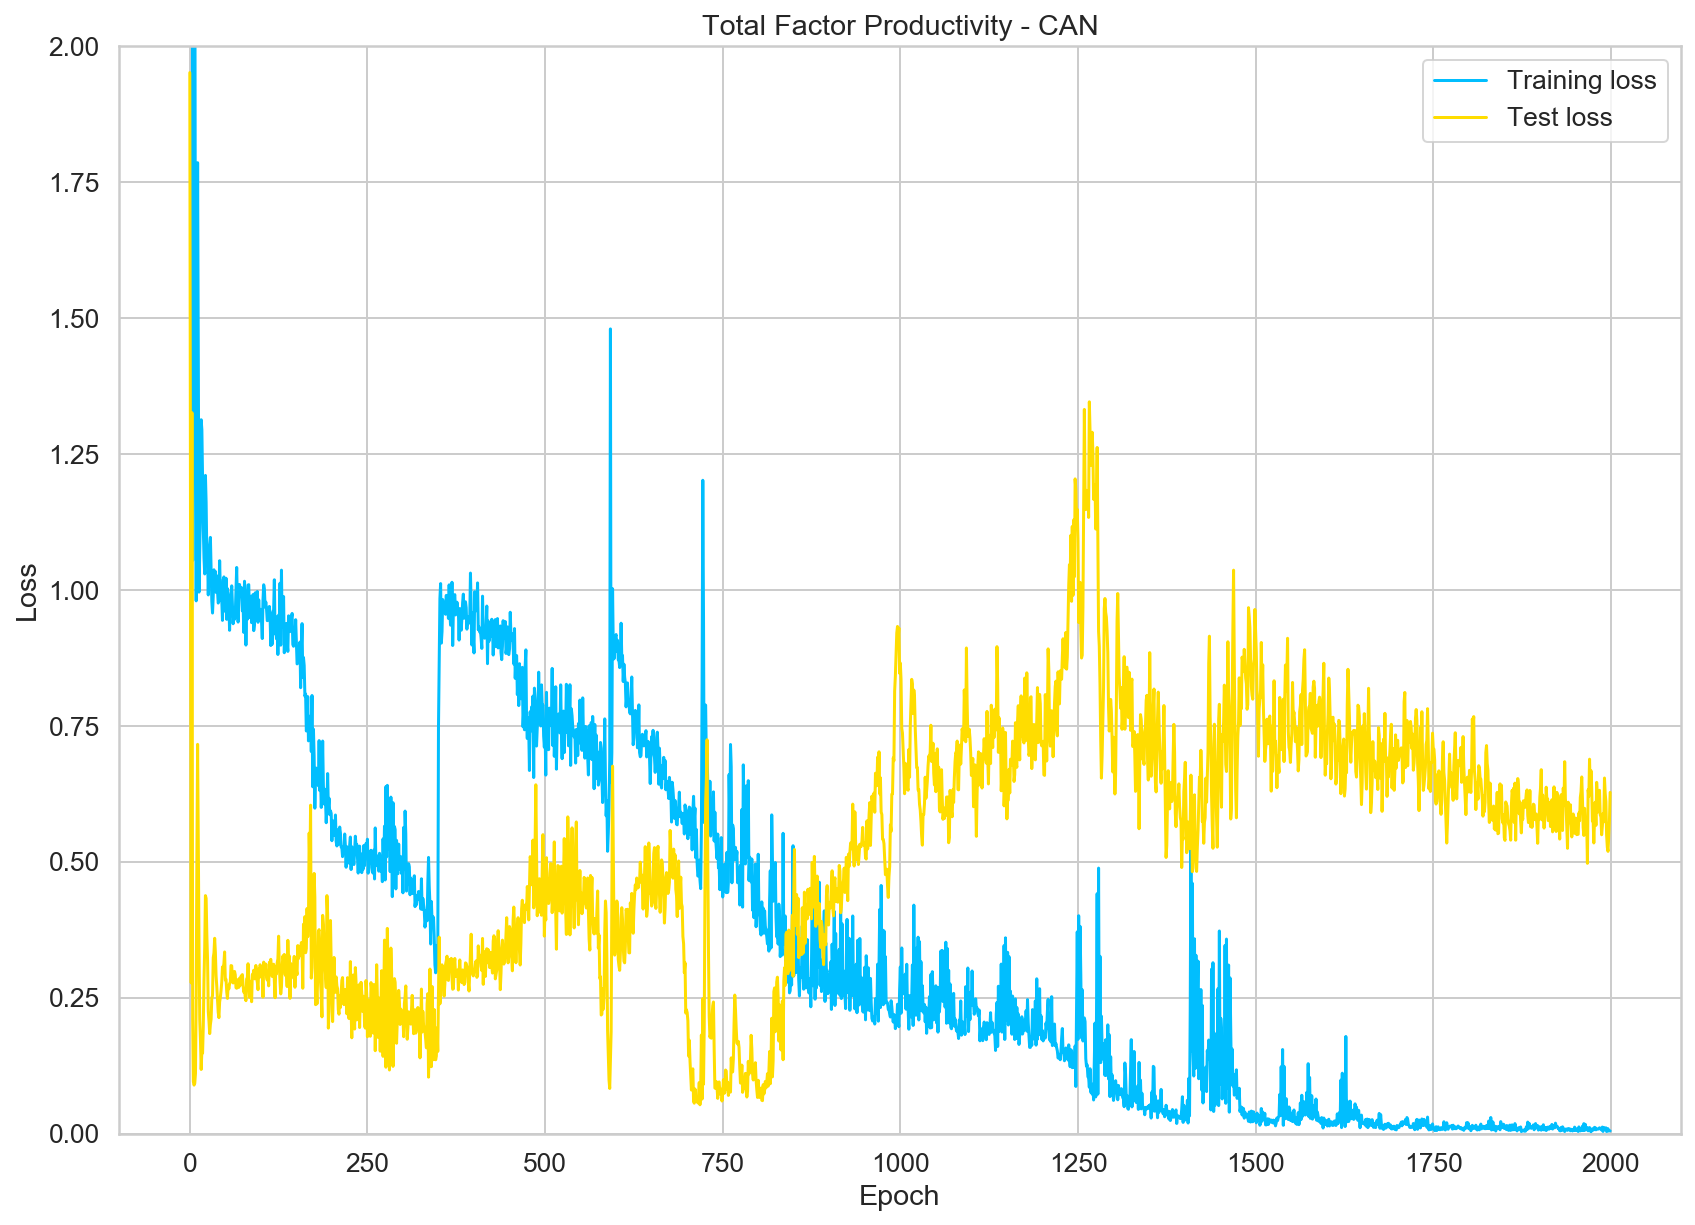

In [68]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 2))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Total Factor Productivity - CAN")
plt.legend();

Our model's performance does not improve after 1750 epochs or so.

## Predicting yearly data

Our model can (due to the way we've trained it) predict only a single year in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next years:

In [69]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

We have to reverse the scaling of the test data and the model predictions:

In [70]:
true_data = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

true_data

array([0.99999994, 0.9951318 , 0.98143286, 0.958357  , 0.9264822 ,
       0.9325666 ], dtype=float32)

In [71]:
predicted_data = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

predicted_data

array([1.04251666, 1.03609092, 1.01808878, 0.9990948 , 0.98174419,
       0.96469645])

Let's look at the results:

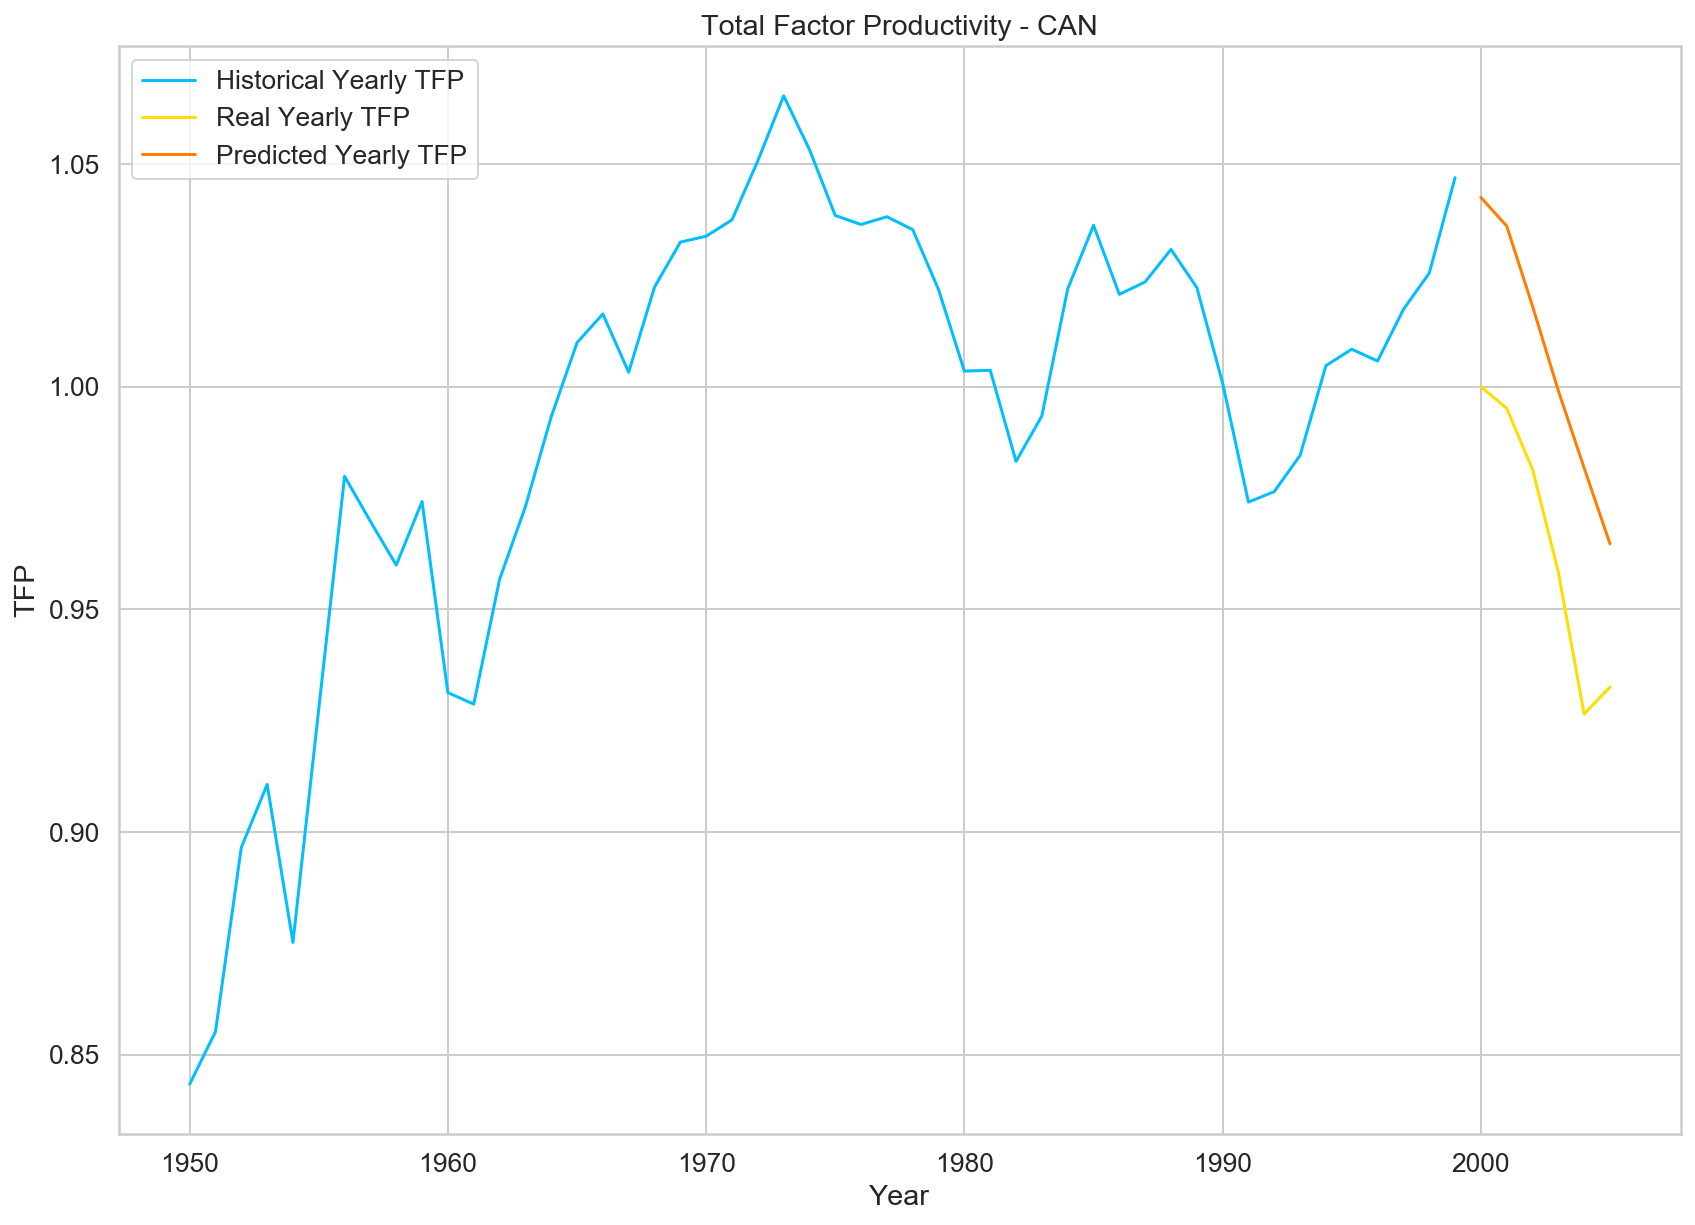

In [72]:
plt.plot(
  can.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Yearly TFP'
)

plt.plot(
  can.index[len(train_data):len(train_data) + len(true_data)], 
  true_data,
  label='Real Yearly TFP'
)

plt.plot(
  can.index[len(train_data):len(train_data) + len(true_data)], 
  predicted_data, 
  label='Predicted Yearly TFP'
)
plt.xlabel('Year')
plt.ylabel('TFP')
plt.title("Total Factor Productivity - CAN")
plt.legend();

Our model was able to catch the proper trend.

## Use all data for training

Now, we'll use all available data to train the same model:

In [73]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(can, axis=1))

all_data = scaler.transform(np.expand_dims(can, axis=1))

all_data.shape

(62, 1)

The preprocessing and training steps are the same:

In [74]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = TFPPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all, None, None, 2000)

Epoch 0 train loss: 23.79216957092285
Epoch 10 train loss: 1.0633314847946167
Epoch 20 train loss: 1.0136592388153076
Epoch 30 train loss: 1.0831691026687622
Epoch 40 train loss: 1.0463364124298096
Epoch 50 train loss: 1.0021713972091675
Epoch 60 train loss: 0.9732333421707153
Epoch 70 train loss: 0.9684537053108215
Epoch 80 train loss: 0.9624329209327698
Epoch 90 train loss: 0.9333564043045044
Epoch 100 train loss: 0.950660765171051
Epoch 110 train loss: 0.9519611597061157
Epoch 120 train loss: 0.9898330569267273
Epoch 130 train loss: 0.9731847643852234
Epoch 140 train loss: 0.9098957180976868
Epoch 150 train loss: 0.9308634996414185
Epoch 160 train loss: 0.9846399426460266
Epoch 170 train loss: 0.9464321136474609
Epoch 180 train loss: 0.8813029527664185
Epoch 190 train loss: 0.8948589563369751
Epoch 200 train loss: 0.7261963486671448
Epoch 210 train loss: 0.7549610137939453
Epoch 220 train loss: 0.7960782647132874
Epoch 230 train loss: 0.7076914310455322
Epoch 240 train loss: 0.64676

Epoch 1940 train loss: 0.0029083455447107553
Epoch 1950 train loss: 0.006693207658827305
Epoch 1960 train loss: 0.004764738492667675
Epoch 1970 train loss: 0.00729990703985095
Epoch 1980 train loss: 0.004942747764289379
Epoch 1990 train loss: 0.003757860977202654


Let's have a look at the train loss:

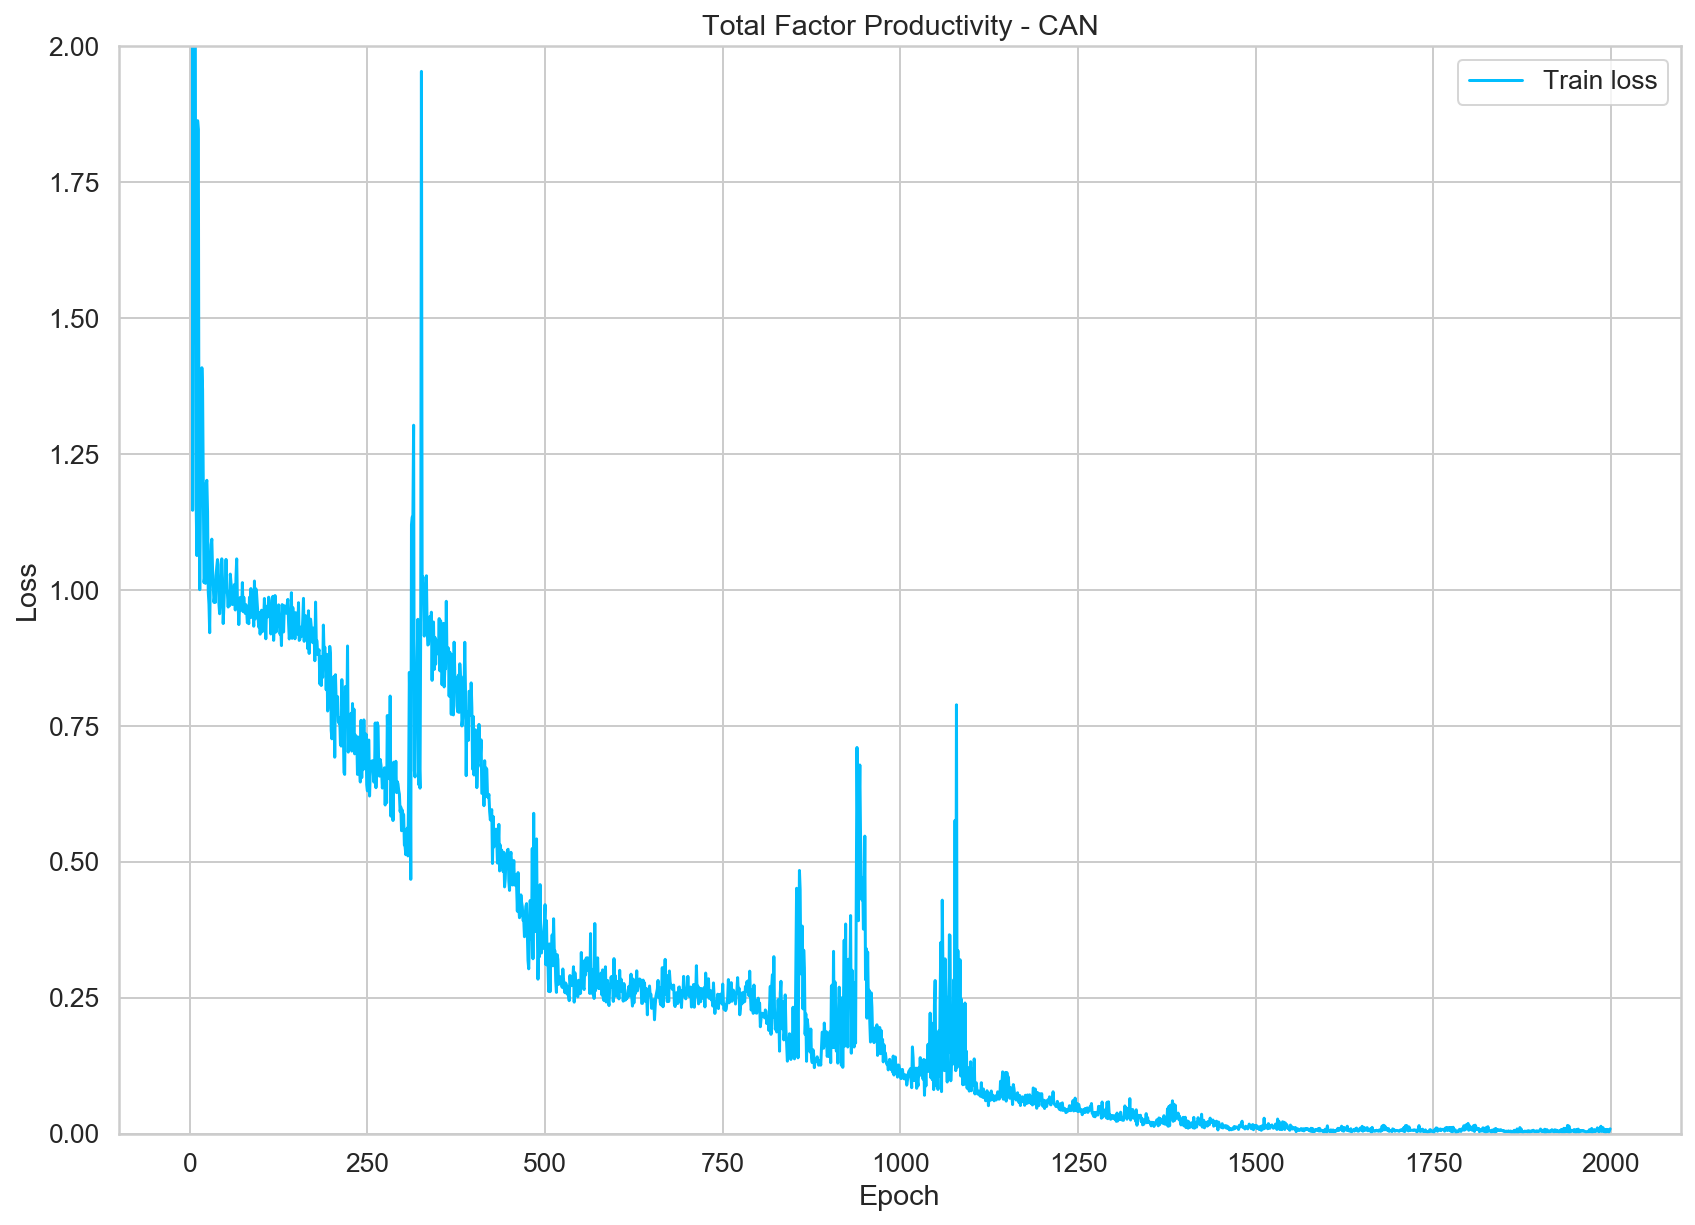

In [75]:
plt.plot(train_hist, label="Train loss")
plt.ylim((0, 2))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Total Factor Productivity - CAN")
plt.legend();

## Predicting future cases

We'll use our "fully trained" model to predict the TFP for 10 years into the future:

In [76]:
YEARS_TO_PREDICT = 10

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(YEARS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

As before, we'll inverse the scaler transformation:

In [77]:
predicted_data = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
predicted_data

array([0.99492798, 0.98644174, 0.95472466, 0.9788833 , 1.03121012,
       1.0597919 , 1.02947614, 1.00015839, 1.03101433, 0.99075237])

To create a cool chart with the historical and predicted cases, we need to extend the date index of our data frame:

In [78]:
can.index[-1]

Timestamp('2011-01-01 00:00:00')

In [79]:
predicted_index = pd.date_range(
  start=can.index[-1],
  freq='Y',
  periods=YEARS_TO_PREDICT
)

predicted_index

DatetimeIndex(['2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31',
               '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31',
               '2019-12-31', '2020-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

In [80]:
predicted_data = pd.Series(
  data=predicted_data,
  index=predicted_index
)

predicted_data

2011-12-31    0.994928
2012-12-31    0.986442
2013-12-31    0.954725
2014-12-31    0.978883
2015-12-31    1.031210
2016-12-31    1.059792
2017-12-31    1.029476
2018-12-31    1.000158
2019-12-31    1.031014
2020-12-31    0.990752
Freq: A-DEC, dtype: float64

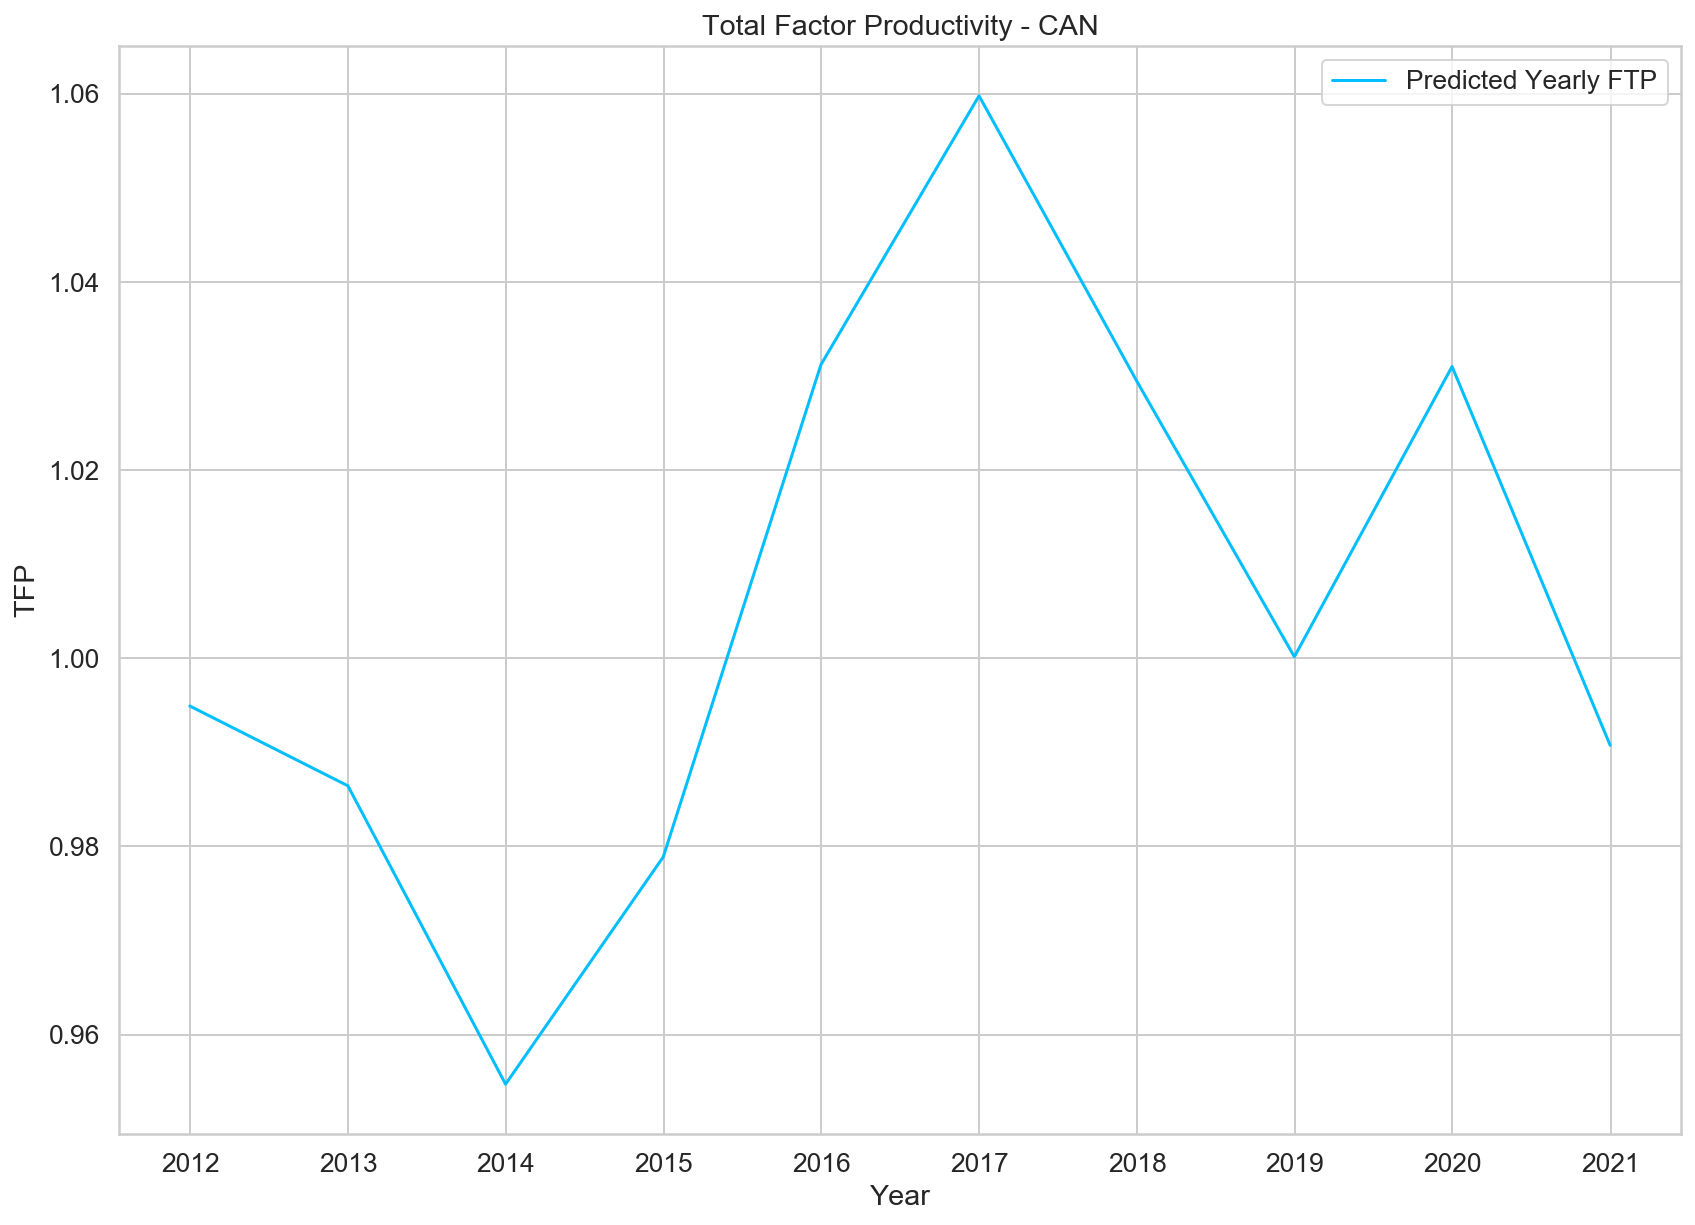

In [81]:
plt.plot(predicted_data, label='Predicted Yearly FTP')
plt.xlabel('Year')
plt.ylabel('TFP')
plt.title("Total Factor Productivity - CAN")
plt.legend();

Now we can use all the data to plot the results:

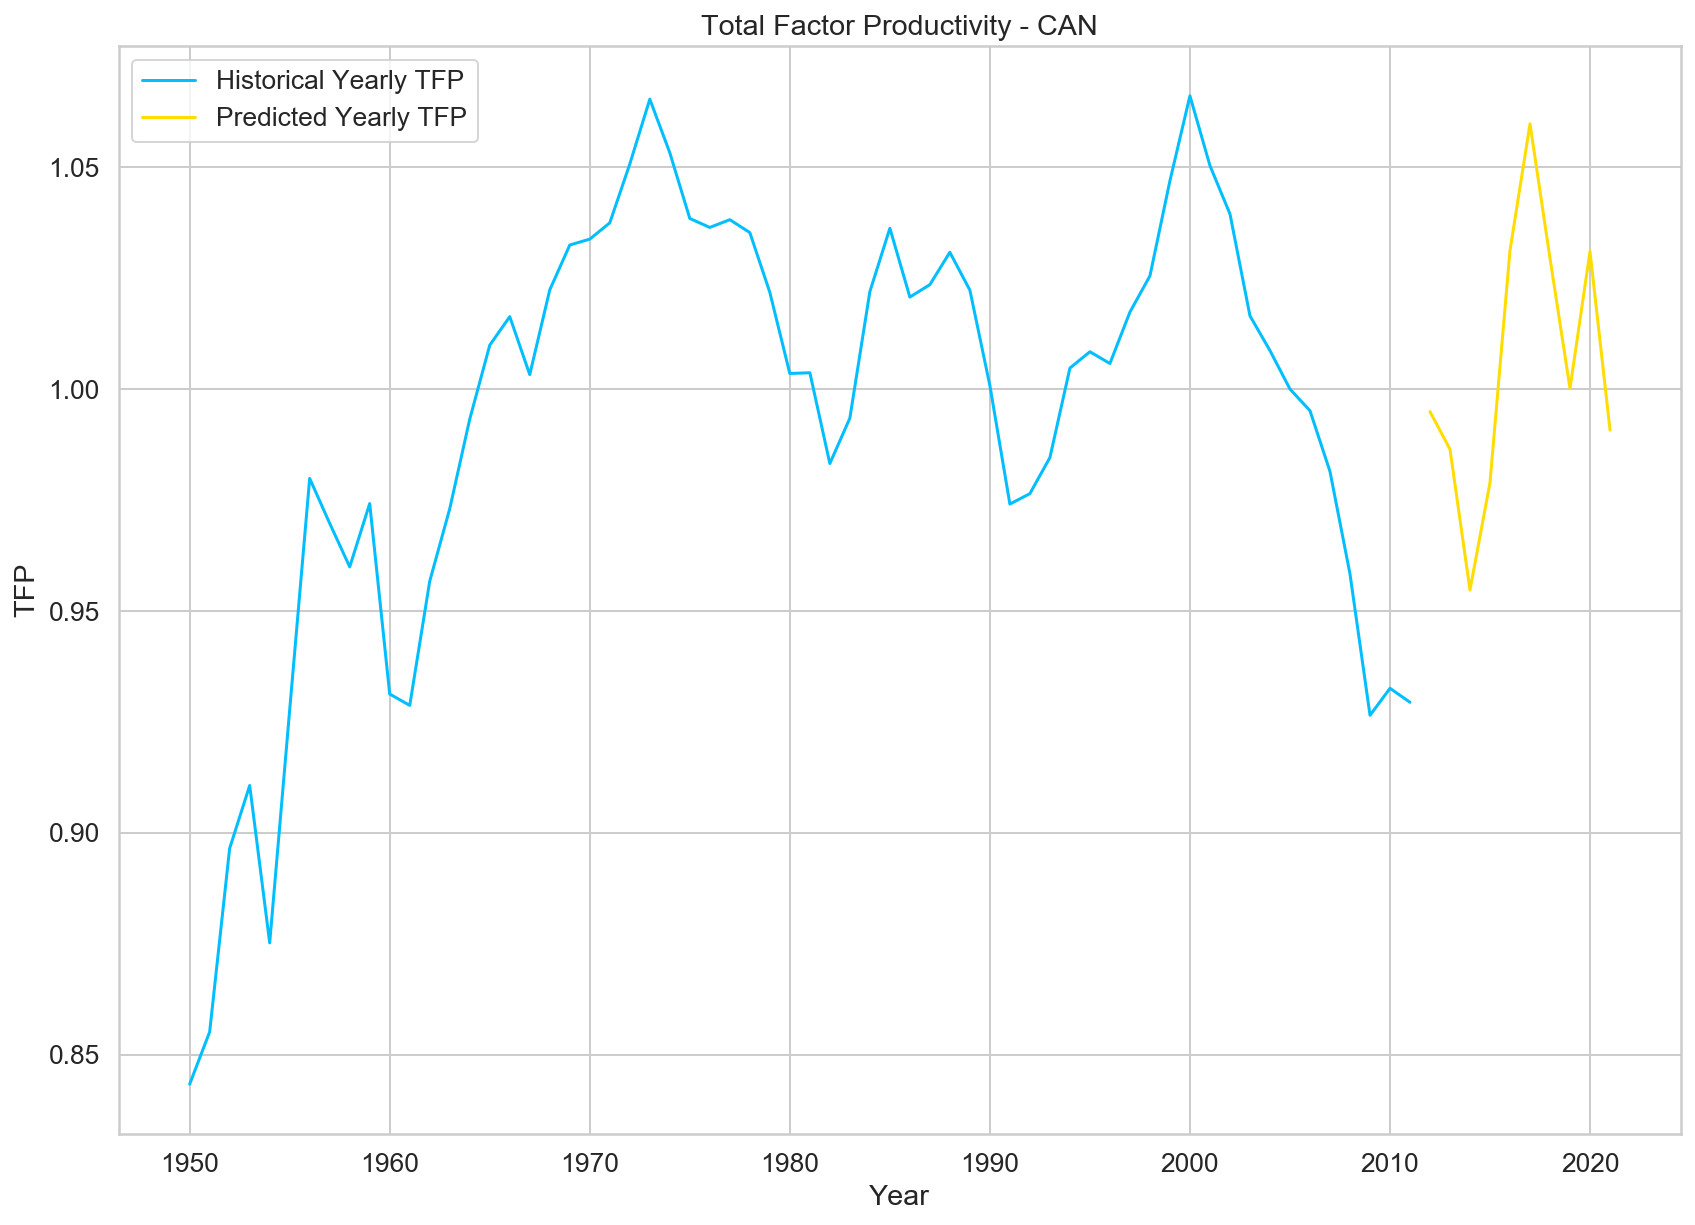

In [82]:
plt.plot(can, label='Historical Yearly TFP')
plt.plot(predicted_data, label='Predicted Yearly TFP')
plt.xlabel('Year')
plt.ylabel('TFP')
plt.title("Total Factor Productivity - CAN")
plt.legend();

Our model thinks that the TFP will keep its fluctuating pattern. Note that the more you go into the future, the more you shouldn't trust your model predictions.

# MEX

## Preprocessing

We'll reserve the last 12 years for testing and use the remaining years for training:

In [83]:
test_data_size = 12

train_data = mex[:-test_data_size]
test_data = mex[-test_data_size:]

train_data.shape

(49,)

We normally scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. We'll use the `MinMaxScaler` from scikit-learn:

In [84]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

Currently, we have a big sequence of yearly data. We'll convert it into smaller ones:

In [85]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let's dive in:

In [86]:
X_train.shape

torch.Size([43, 5, 1])

In [87]:
X_train[:2]

tensor([[[0.0000],
         [0.1072],
         [0.1346],
         [0.0974],
         [0.2237]],

        [[0.1072],
         [0.1346],
         [0.0974],
         [0.2237],
         [0.3137]]])

In [88]:
y_train.shape

torch.Size([43, 1])

In [89]:
y_train[:2]

tensor([[0.3137],
        [0.3911]])

In [90]:
train_data[:10]

array([[0.        ],
       [0.10720028],
       [0.13458664],
       [0.09742   ],
       [0.22373255],
       [0.313699  ],
       [0.39108093],
       [0.4711365 ],
       [0.50104412],
       [0.49082084]])

## Training

Let's create an instance of our model and train it:

In [91]:
model = TFPPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test,
  2000
)

Epoch 0 train loss: 23.282596588134766 test loss: 0.6956388354301453
Epoch 10 train loss: 2.4076626300811768 test loss: 1.1676417589187622
Epoch 20 train loss: 2.140413761138916 test loss: 0.9384994506835938
Epoch 30 train loss: 1.9195741415023804 test loss: 0.8443512320518494
Epoch 40 train loss: 1.923526406288147 test loss: 0.8289663195610046
Epoch 50 train loss: 1.9129712581634521 test loss: 0.8273043632507324
Epoch 60 train loss: 2.0834193229675293 test loss: 0.7038413882255554
Epoch 70 train loss: 2.1045703887939453 test loss: 0.6453605890274048
Epoch 80 train loss: 1.9151579141616821 test loss: 0.7955518960952759
Epoch 90 train loss: 1.8648070096969604 test loss: 0.64031982421875
Epoch 100 train loss: 1.9649560451507568 test loss: 0.3129231035709381
Epoch 110 train loss: 1.8708467483520508 test loss: 0.7322142720222473
Epoch 120 train loss: 1.9460889101028442 test loss: 0.6988598704338074
Epoch 130 train loss: 1.8945306539535522 test loss: 0.7559035420417786
Epoch 140 train loss:

Epoch 1140 train loss: 0.04662909358739853 test loss: 0.22374776005744934
Epoch 1150 train loss: 0.05500566214323044 test loss: 0.2818843722343445
Epoch 1160 train loss: 0.04867836833000183 test loss: 0.2036638855934143
Epoch 1170 train loss: 0.04814549535512924 test loss: 0.2485547661781311
Epoch 1180 train loss: 0.11547444760799408 test loss: 0.16975203156471252
Epoch 1190 train loss: 0.05442008003592491 test loss: 0.2471483051776886
Epoch 1200 train loss: 0.0572192557156086 test loss: 0.23686295747756958
Epoch 1210 train loss: 0.040334831923246384 test loss: 0.25070229172706604
Epoch 1220 train loss: 0.0639621764421463 test loss: 0.2568550109863281
Epoch 1230 train loss: 0.03626563400030136 test loss: 0.22355148196220398
Epoch 1240 train loss: 0.06972098350524902 test loss: 0.2522740364074707
Epoch 1250 train loss: 0.043397195637226105 test loss: 0.1905803084373474
Epoch 1260 train loss: 0.04568437114357948 test loss: 0.23008084297180176
Epoch 1270 train loss: 0.07455720752477646 te

Let's have a look at the train and test loss:

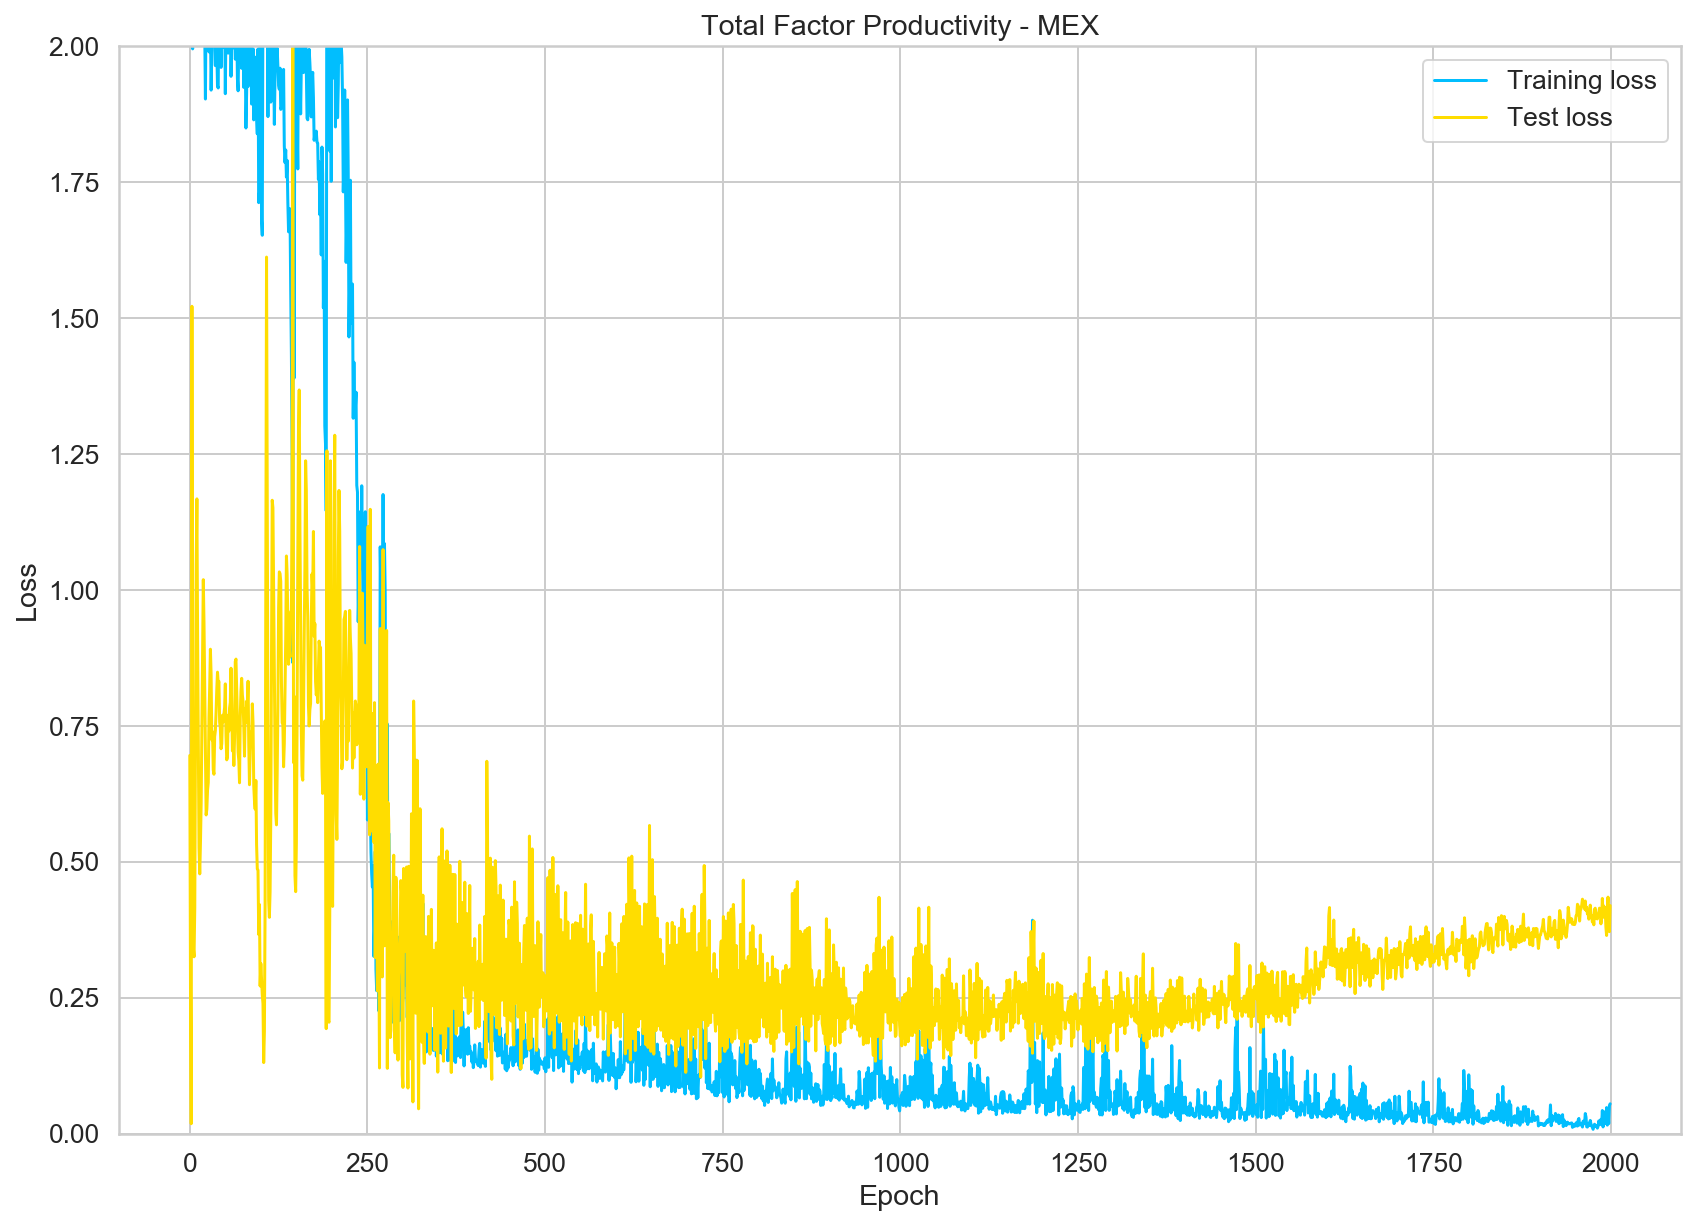

In [92]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 2))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Total Factor Productivity - MEX")
plt.legend();

Our model's performance does not improve after 1750 epochs or so.

## Predicting yearly data

Our model can (due to the way we've trained it) predict only a single year in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next years:

In [93]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

We have to reverse the scaling of the test data and the model predictions:

In [94]:
true_data = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

true_data

array([0.99496275, 1.        , 1.0117506 , 1.0136733 , 0.9915478 ,
       0.91587853], dtype=float32)

In [95]:
predicted_data = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

predicted_data

array([1.15625078, 1.16595411, 1.16395712, 1.14668382, 1.12138511,
       1.09965754])

Let's look at the results:

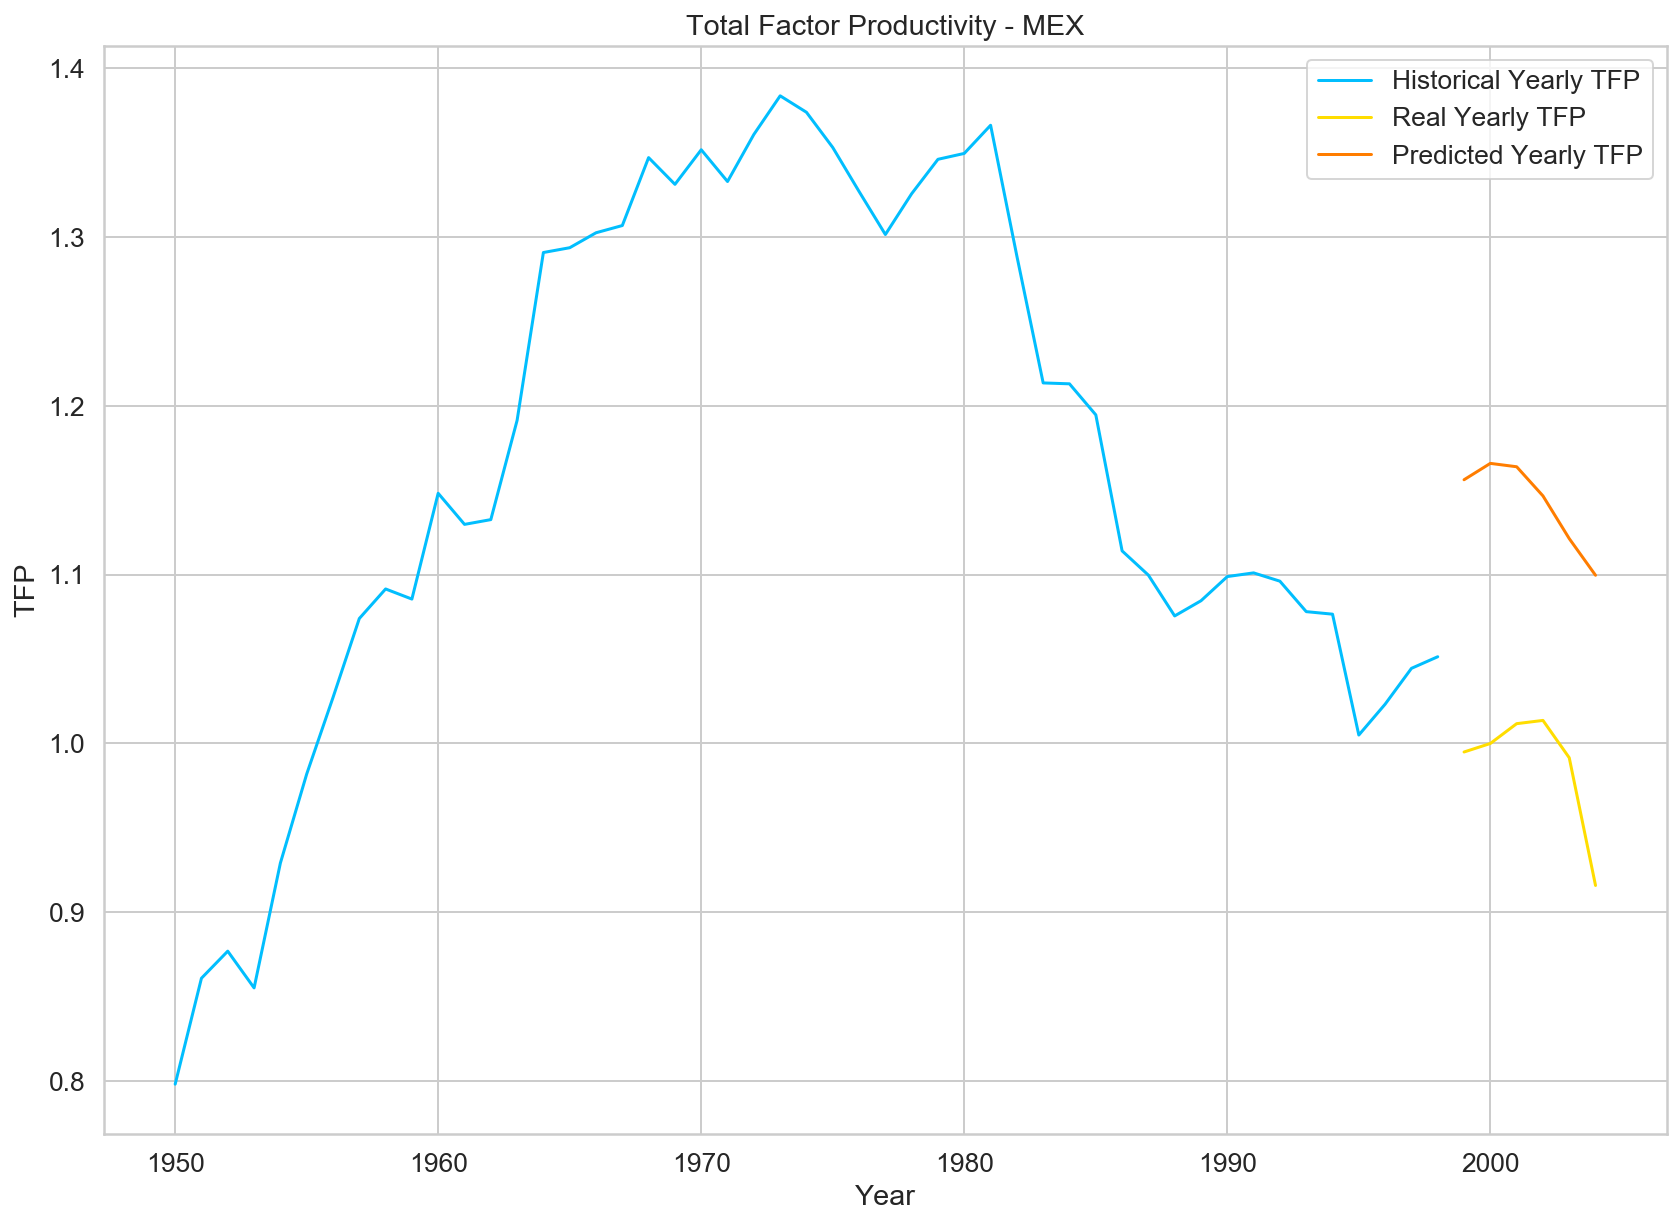

In [96]:
plt.plot(
  mex.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Yearly TFP'
)

plt.plot(
  mex.index[len(train_data):len(train_data) + len(true_data)], 
  true_data,
  label='Real Yearly TFP'
)

plt.plot(
  mex.index[len(train_data):len(train_data) + len(true_data)], 
  predicted_data, 
  label='Predicted Yearly TFP'
)
plt.xlabel('Year')
plt.ylabel('TFP')
plt.title("Total Factor Productivity - MEX")
plt.legend();

Our model was able to catch the proper trend.

## Use all data for training

Now, we'll use all available data to train the same model:

In [97]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(mex, axis=1))

all_data = scaler.transform(np.expand_dims(can, axis=1))

all_data.shape

(62, 1)

The preprocessing and training steps are the same:

In [98]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = TFPPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all, None, None, 2000)

Epoch 0 train loss: 24.30726432800293
Epoch 10 train loss: 3.7231743335723877
Epoch 20 train loss: 2.358017921447754
Epoch 30 train loss: 2.172482490539551
Epoch 40 train loss: 2.1551125049591064
Epoch 50 train loss: 1.9660283327102661
Epoch 60 train loss: 2.0440337657928467
Epoch 70 train loss: 1.9583412408828735
Epoch 80 train loss: 2.043142318725586
Epoch 90 train loss: 2.109761953353882
Epoch 100 train loss: 1.972260594367981
Epoch 110 train loss: 2.027864933013916
Epoch 120 train loss: 2.0683817863464355
Epoch 130 train loss: 2.0334837436676025
Epoch 140 train loss: 1.9258754253387451
Epoch 150 train loss: 3.4868648052215576
Epoch 160 train loss: 2.0631794929504395
Epoch 170 train loss: 2.311227798461914
Epoch 180 train loss: 1.9719990491867065
Epoch 190 train loss: 1.9705860614776611
Epoch 200 train loss: 2.009042739868164
Epoch 210 train loss: 1.868666410446167
Epoch 220 train loss: 1.9444313049316406
Epoch 230 train loss: 1.9607689380645752
Epoch 240 train loss: 1.9201383590698

Epoch 1940 train loss: 0.02130254916846752
Epoch 1950 train loss: 0.021784696727991104
Epoch 1960 train loss: 0.024764573201537132
Epoch 1970 train loss: 0.019394775852560997
Epoch 1980 train loss: 0.022645672783255577
Epoch 1990 train loss: 0.021610436961054802


Let's have a look at the train loss:

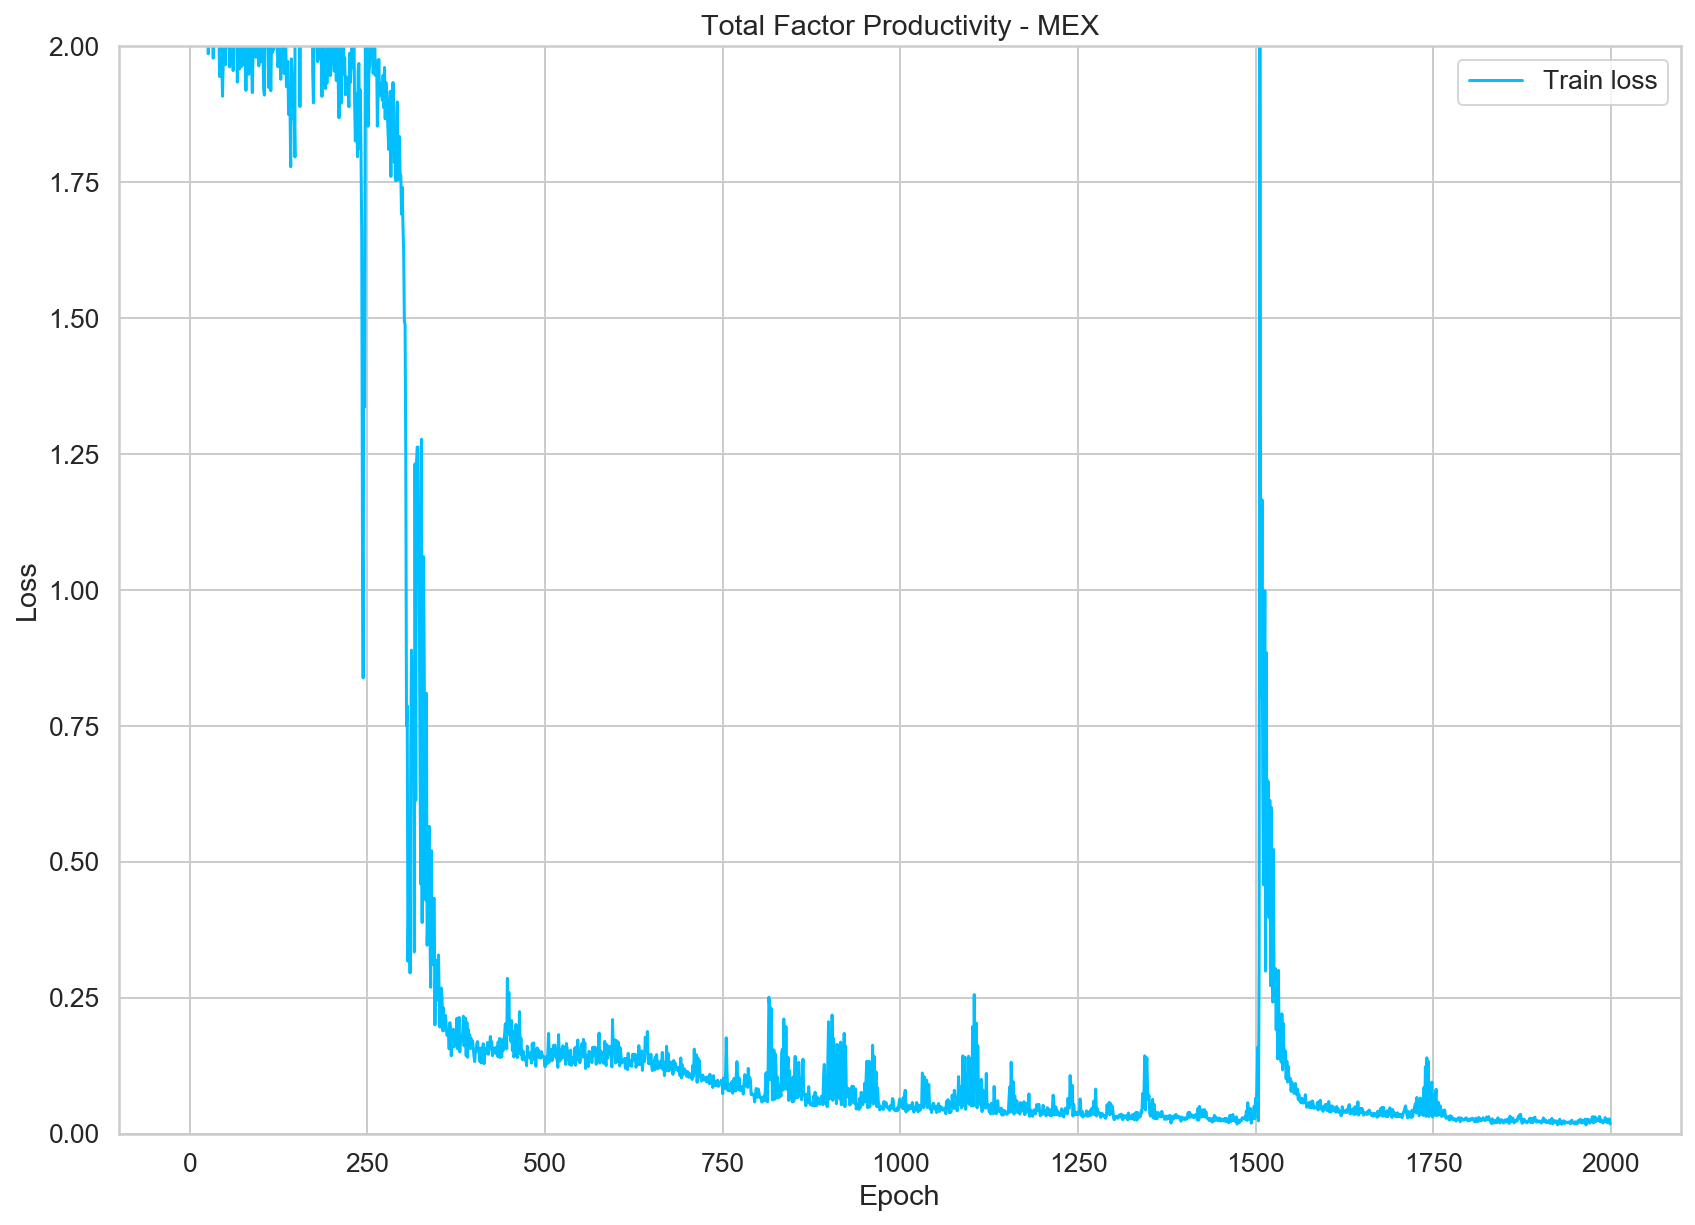

In [99]:
plt.plot(train_hist, label="Train loss")
plt.ylim((0, 2))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Total Factor Productivity - MEX")
plt.legend();

## Predicting future cases

We'll use our "fully trained" model to predict the TFP for 10 years into the future:

In [100]:
YEARS_TO_PREDICT = 10

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(YEARS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

As before, we'll inverse the scaler transformation:

In [101]:
predicted_data = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
predicted_data

array([1.02494578, 1.08906051, 1.14629599, 1.27763153, 1.34295111,
       1.30130115, 1.30494468, 1.0858609 , 1.04552507, 0.92333158])

To create a cool chart with the historical and predicted cases, we need to extend the date index of our data frame:

In [102]:
mex.index[-1]

Timestamp('2010-01-01 00:00:00')

In [103]:
predicted_index = pd.date_range(
  start=mex.index[-1],
  freq='Y',
  periods=YEARS_TO_PREDICT
)

predicted_index

DatetimeIndex(['2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31',
               '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31',
               '2018-12-31', '2019-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

In [104]:
predicted_data = pd.Series(
  data=predicted_data,
  index=predicted_index
)

predicted_data

2010-12-31    1.024946
2011-12-31    1.089061
2012-12-31    1.146296
2013-12-31    1.277632
2014-12-31    1.342951
2015-12-31    1.301301
2016-12-31    1.304945
2017-12-31    1.085861
2018-12-31    1.045525
2019-12-31    0.923332
Freq: A-DEC, dtype: float64

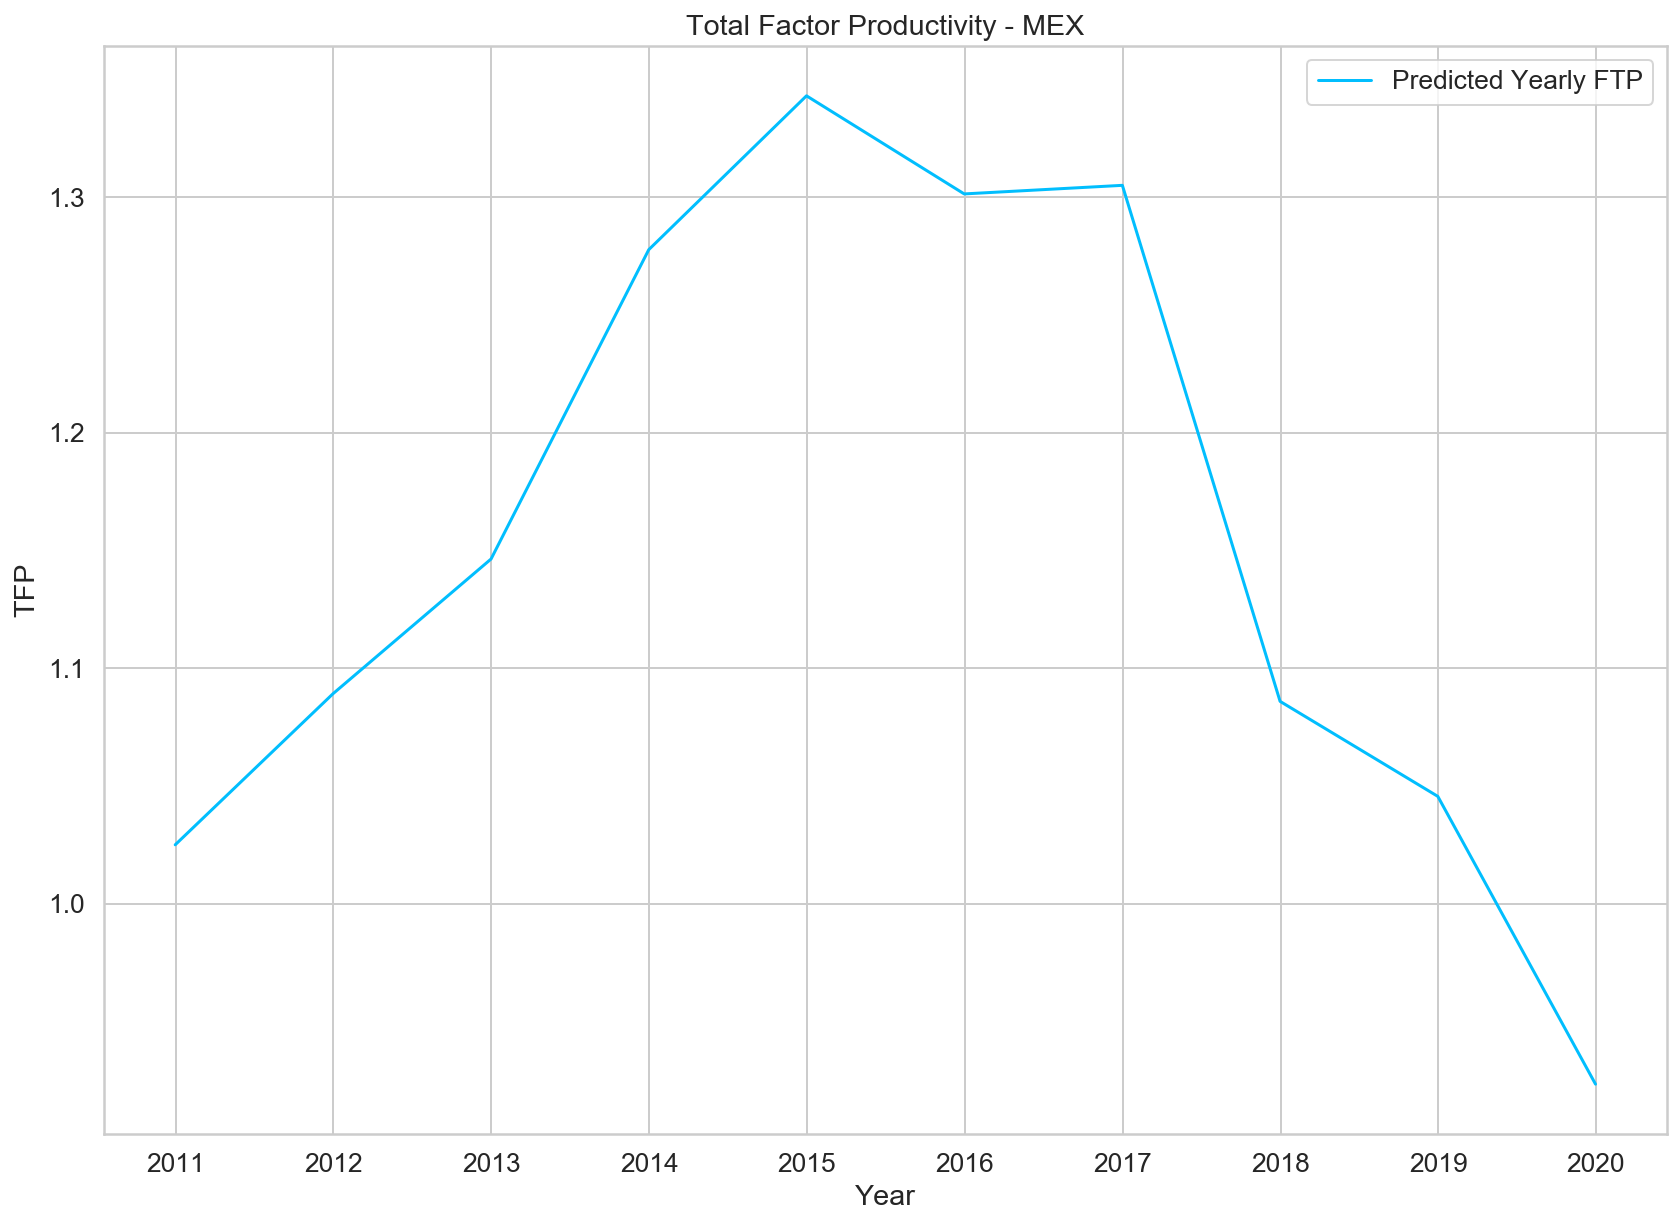

In [105]:
plt.plot(predicted_data, label='Predicted Yearly FTP')
plt.xlabel('Year')
plt.ylabel('TFP')
plt.title("Total Factor Productivity - MEX")
plt.legend();

Now we can use all the data to plot the results:

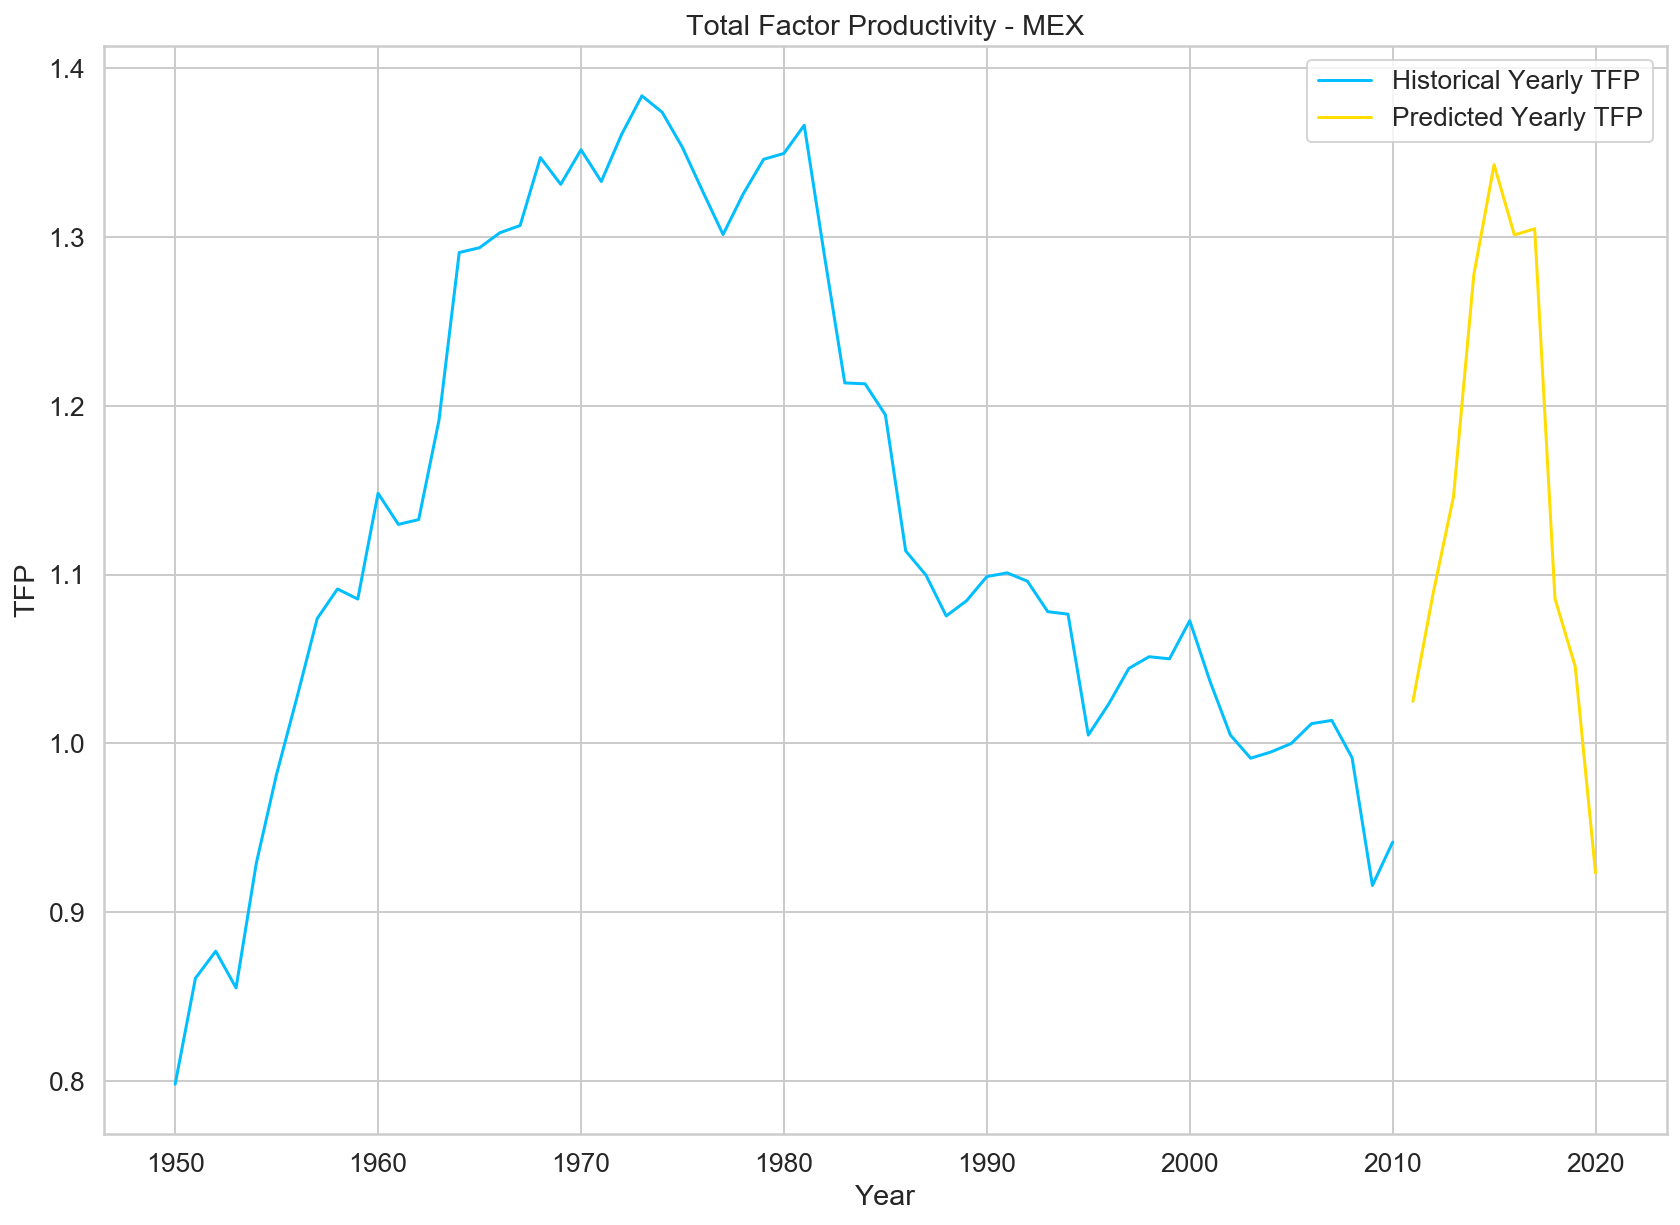

In [106]:
plt.plot(mex, label='Historical Yearly TFP')
plt.plot(predicted_data, label='Predicted Yearly TFP')
plt.xlabel('Year')
plt.ylabel('TFP')
plt.title("Total Factor Productivity - MEX")
plt.legend();

Our model thinks that the TFP will keep its fluctuating pattern. Note that the more you go into the future, the more you shouldn't trust your model predictions.

## Conclusion

Time Series Forecasting with LSTMs is more appropriate for small time steps, due to the use of the last data point as a strong predictor for the next. The use of more features could help to improve short term predictions.

Analysing all variables in the original dataset and based on the way TFP is calculated my best guess (I am not an economist) is to use cgdpo = Output-side GDP at current PPPs (in million 2005 USD) as another feature to explain TFP series because both features are correlated.